https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification/discussion

To predict whether the customer will claim insurance claims within the next 6 months or so.

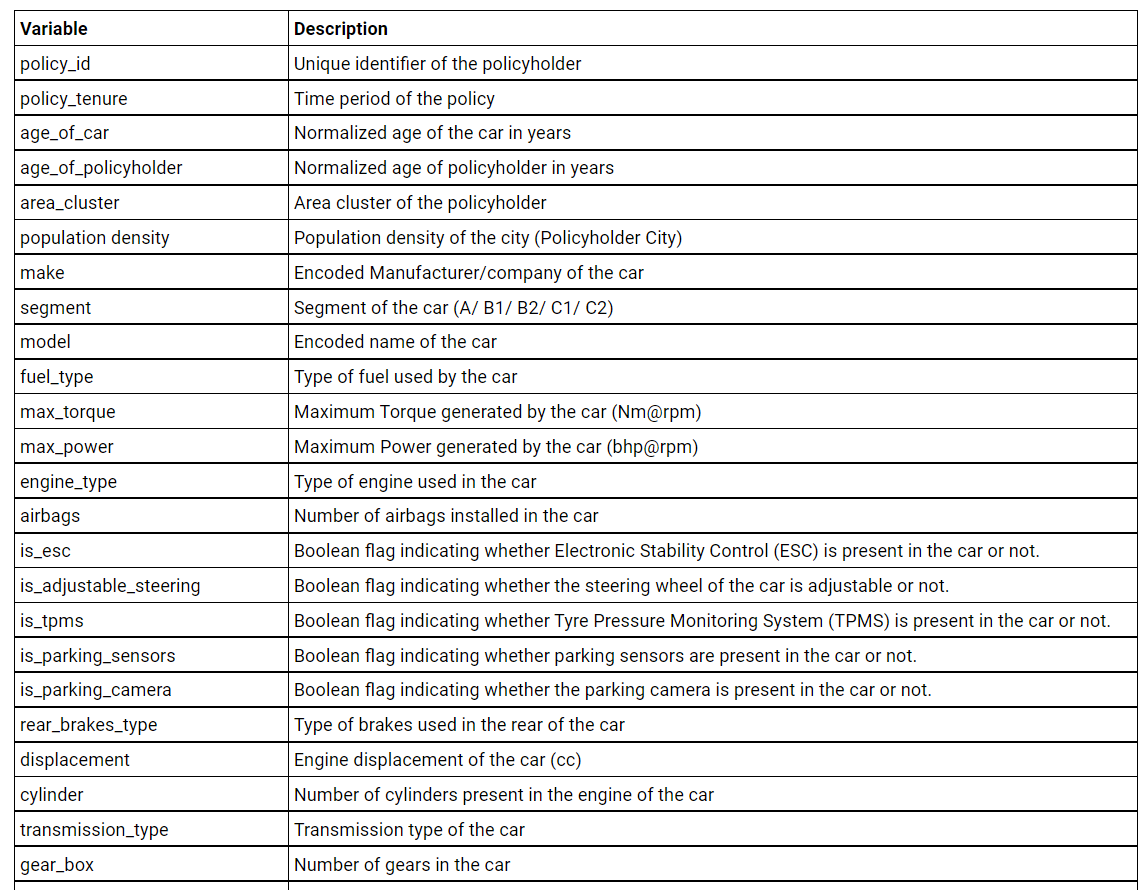

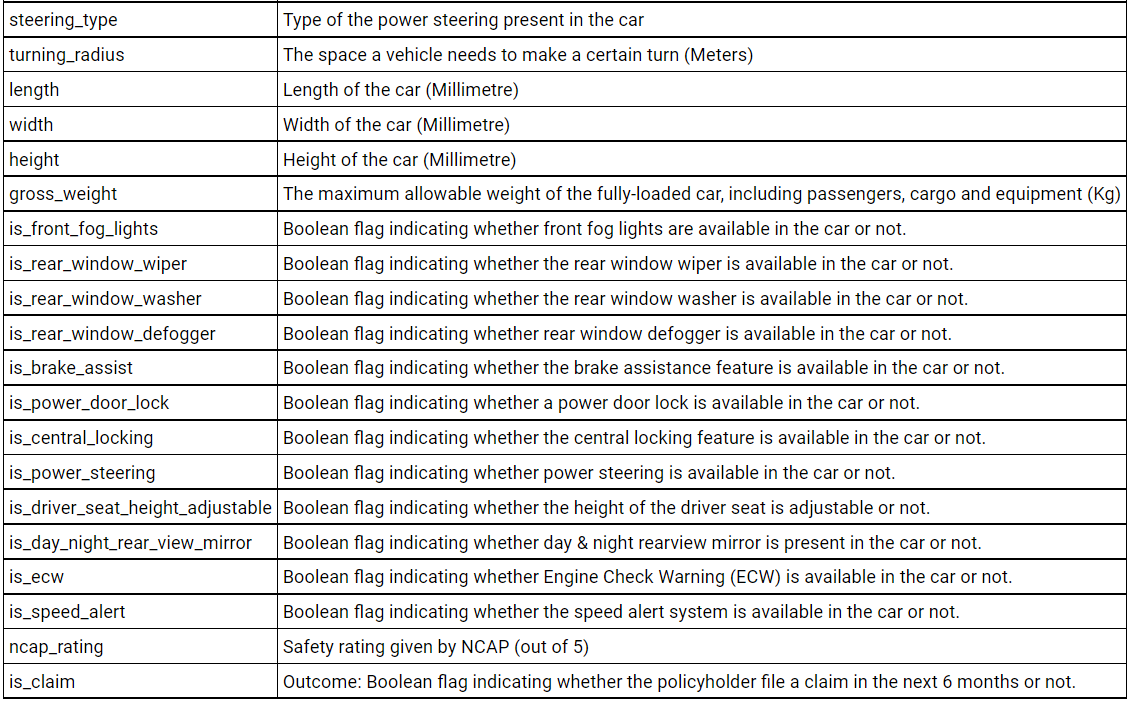

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn import svm
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [2]:
df=pd.read_csv("train.csv")
df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [3]:
df.shape

(58592, 44)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [5]:
df["is_claim"].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

In [6]:
df.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [7]:
df.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

In [8]:
df.drop("policy_id",axis=1,inplace=True)

In [9]:
##Extracting numericals from max_torque and max_power
df["max_torque_Nm"] = df["max_torque"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*Nm)").astype('float64')
df["max_torque_rpm"]=df["max_torque"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*rpm)").astype('float64')

df["max_power_bp"]=df["max_power"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*bhp)").astype("float64")
df["max_power_rpm"]=df["max_power"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*rpm)").astype("float64")

df.drop(["max_torque","max_power"],axis=1,inplace=True)

In [10]:
##To keep the y-variable intact
claim_df=df["is_claim"]

In [11]:
##To drop is_claim to check z-scores
df.drop("is_claim",axis=1,inplace=True)

In [12]:
##Removing outliers by keeping rows where there are z-scores of less than 3 (absolute), since more than 3 standard deviations away appear to be outliers
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df=df[(np.abs(stats.zscore(df[df.select_dtypes(numerics).columns]))<3).all(axis=1)]

In [13]:
df["is_claim"]=claim_df

In [14]:
df.reset_index(drop=True)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,max_torque_Nm,max_torque_rpm,max_power_bp,max_power_rpm,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,1.2 L K12N Dualjet,...,Yes,Yes,Yes,Yes,2,113.0,4400.0,88.50,6000.0,0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,1.0 SCe,...,No,Yes,Yes,Yes,2,91.0,4250.0,67.06,5500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53860,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,1.0 SCe,...,No,Yes,Yes,Yes,2,91.0,4250.0,67.06,5500.0,0
53861,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
53862,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
53863,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,K Series Dual jet,...,Yes,Yes,Yes,Yes,2,113.0,4400.0,88.50,6000.0,0


In [15]:
df['engine_type'].unique()

array(['F8D Petrol Engine', '1.2 L K12N Dualjet', '1.0 SCe',
       '1.5 L U2 CRDi', '1.5 Turbocharged Revotorq', 'K Series Dual jet',
       '1.2 L K Series Engine', 'K10C', 'i-DTEC',
       '1.5 Turbocharged Revotron'], dtype=object)

In [16]:
df_num=df.select_dtypes(numerics)
df_cat=df.select_dtypes(exclude=numerics)

In [17]:
df.columns

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster',
       'population_density', 'make', 'segment', 'model', 'fuel_type',
       'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms',
       'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
       'displacement', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'turning_radius', 'length', 'width', 'height',
       'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'max_torque_Nm',
       'max_torque_rpm', 'max_power_bp', 'max_power_rpm', 'is_claim'],
      dtype='object')

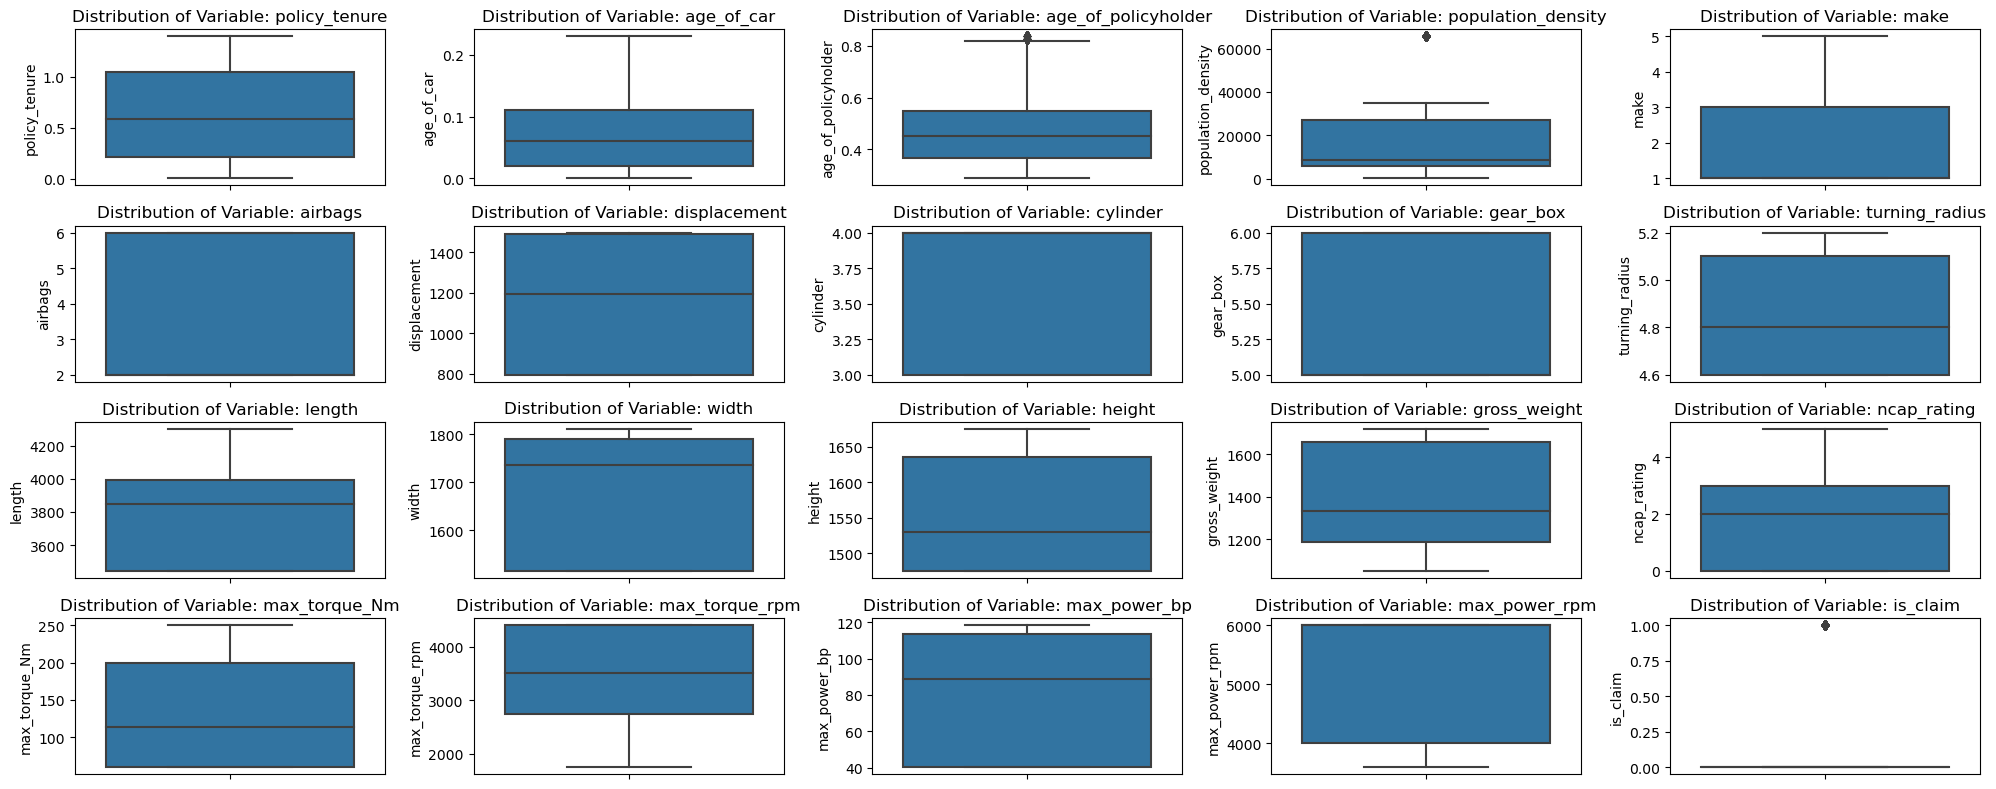

In [18]:
##Checking boxplots for all numerical variables
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 8), sharex = False, sharey = False)  
axes=axes.ravel()
cols = df_num.columns[:]

for col, ax in zip(cols, axes):
    data = df_num
    sns.boxplot(data=data, y=col, ax=ax)
    ax.set(title=f'Distribution of Variable: {col}', xlabel=None)

fig.tight_layout()
plt.show()

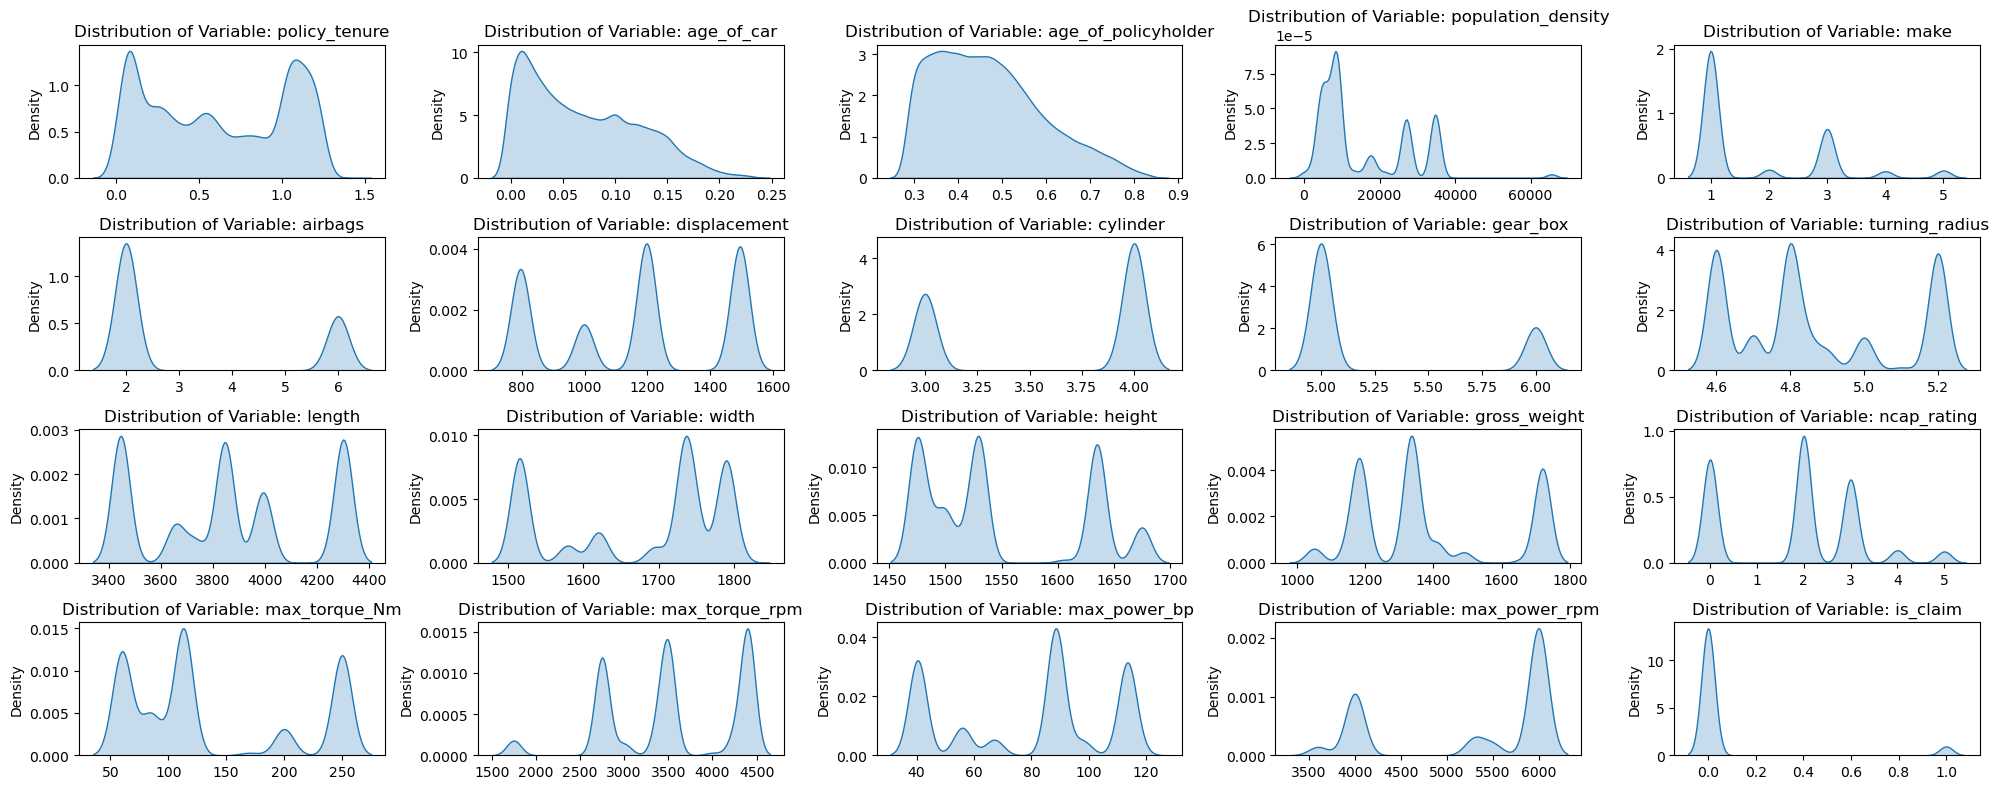

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 8), sharex = False, sharey = False)  
axes=axes.ravel()
cols = df_num.columns[:]

for col, ax in zip(cols, axes):
    data = df_num
    sns.kdeplot(data=data, x=col, fill=True, ax=ax)
    ax.set(title=f'Distribution of Variable: {col}', xlabel=None)

fig.tight_layout()
plt.show()

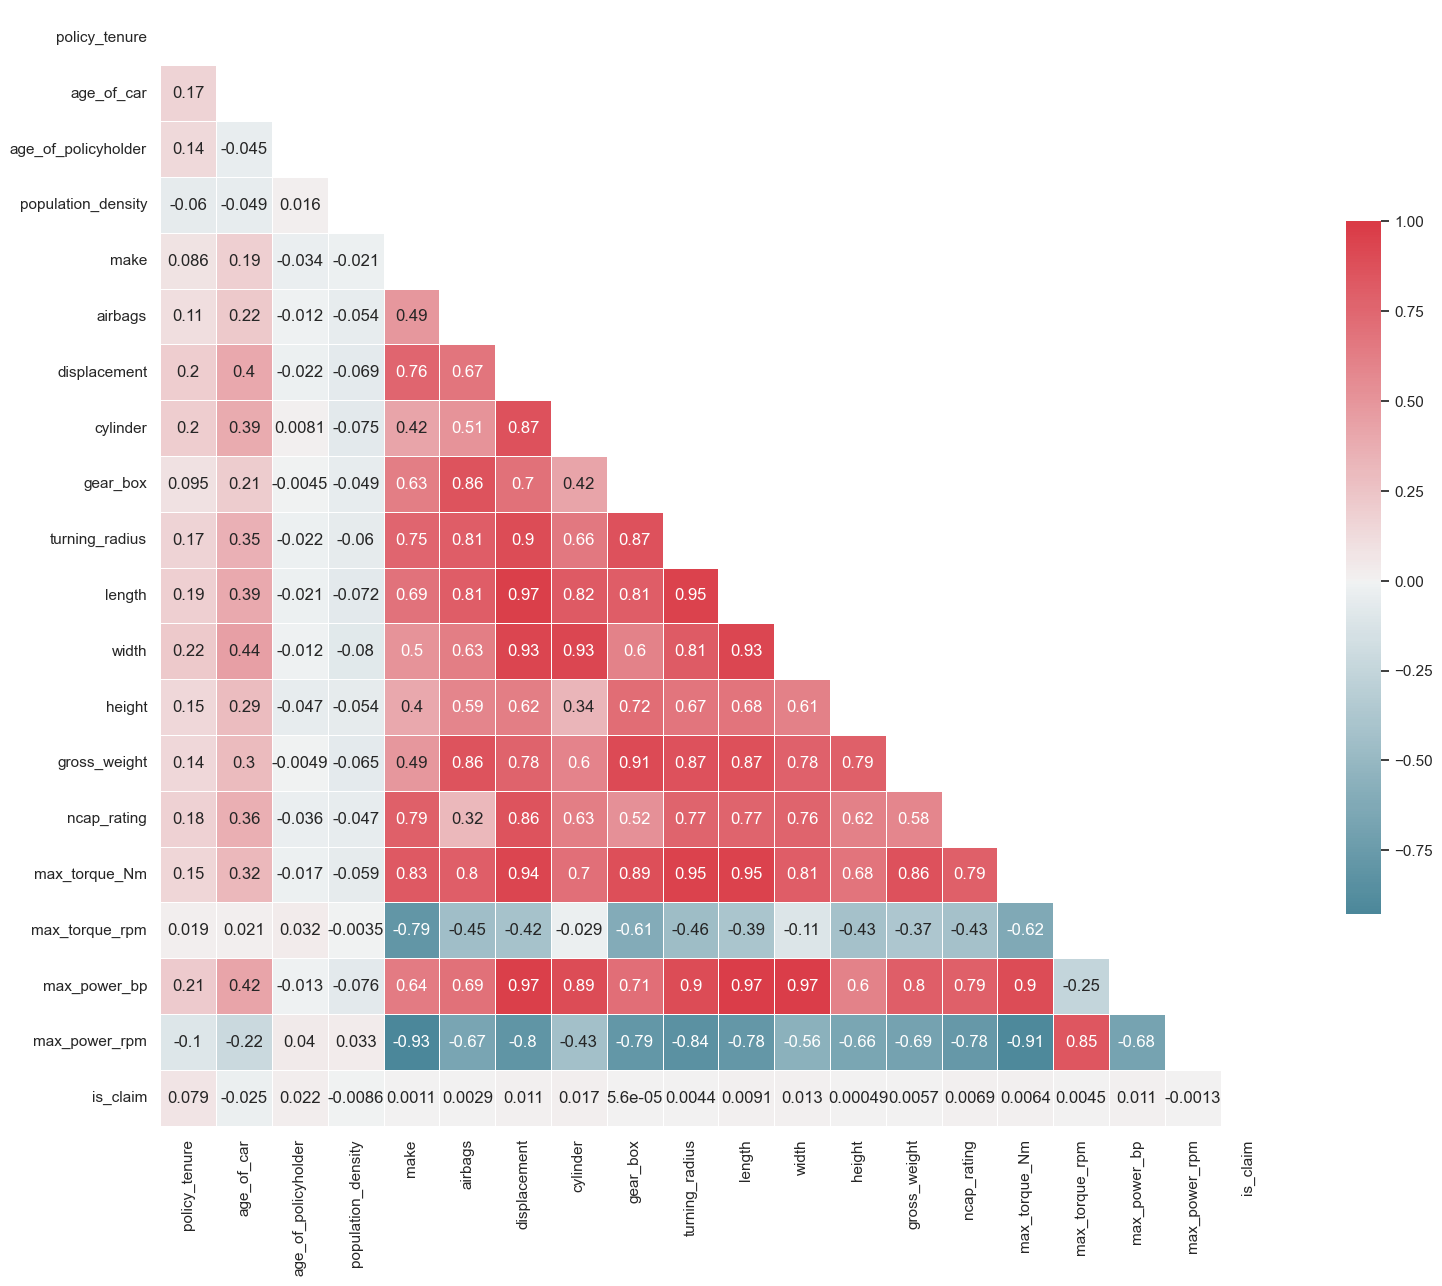

In [20]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(),dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(),mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

In [21]:
def bar_charts(df, feature):
    '''
    Inputs:
    df: Dataset
    feature: Name of Feature to Check With claim
    '''
    _agg = {
        'area_cluster': 'count'
    }
    _groupby = [df['is_claim'], feature]

    df_feature = df.groupby(by=_groupby).agg(_agg)
    # Find the people who had claimed
    ax = df_feature.unstack().plot(kind='bar', figsize=(15,6))
    plt.legend((df_feature.index.levels[1].unique()))
    plt.xlabel('is_claim')
    plt.xticks(np.arange(2), ('0', '1'))
    plt.title("Claims vs"+" "+str(feature))
    plt.show();

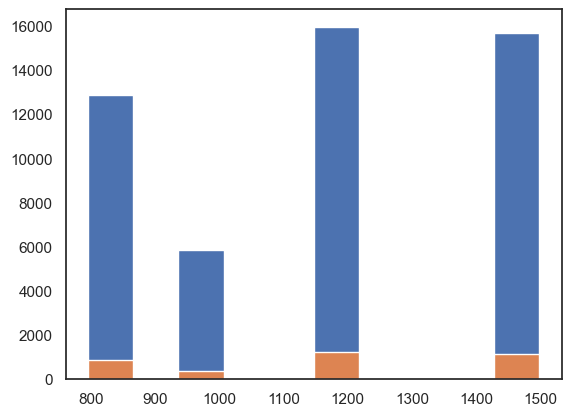

In [107]:
plt.hist(df[df['is_claim']==0]["displacement"],bins=10)
plt.hist(df[df['is_claim']==1]["displacement"],bins=10)
plt.show()

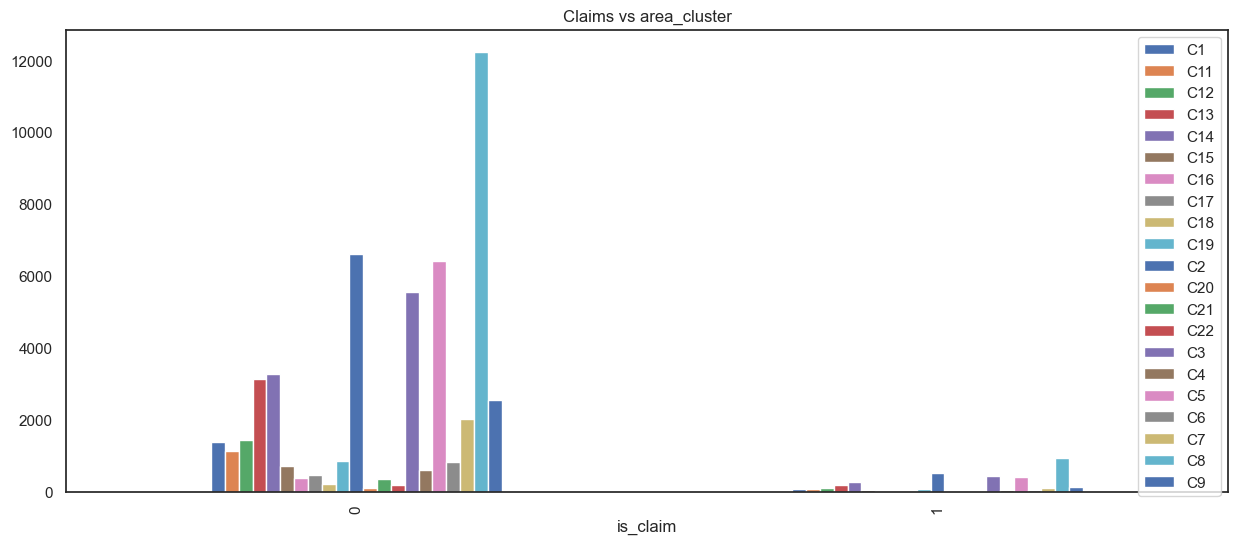

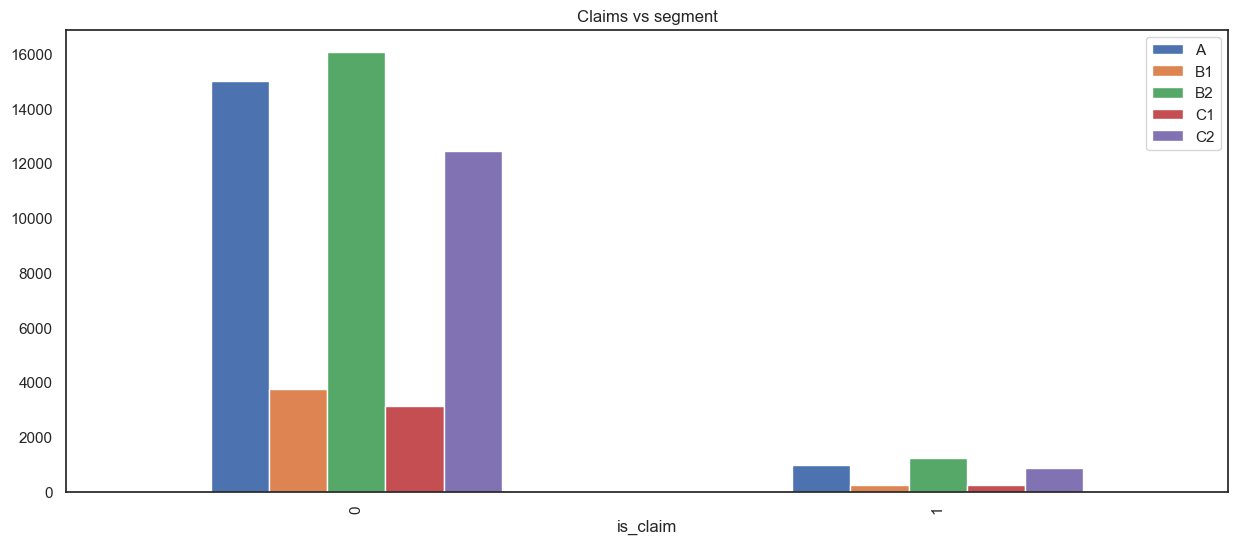

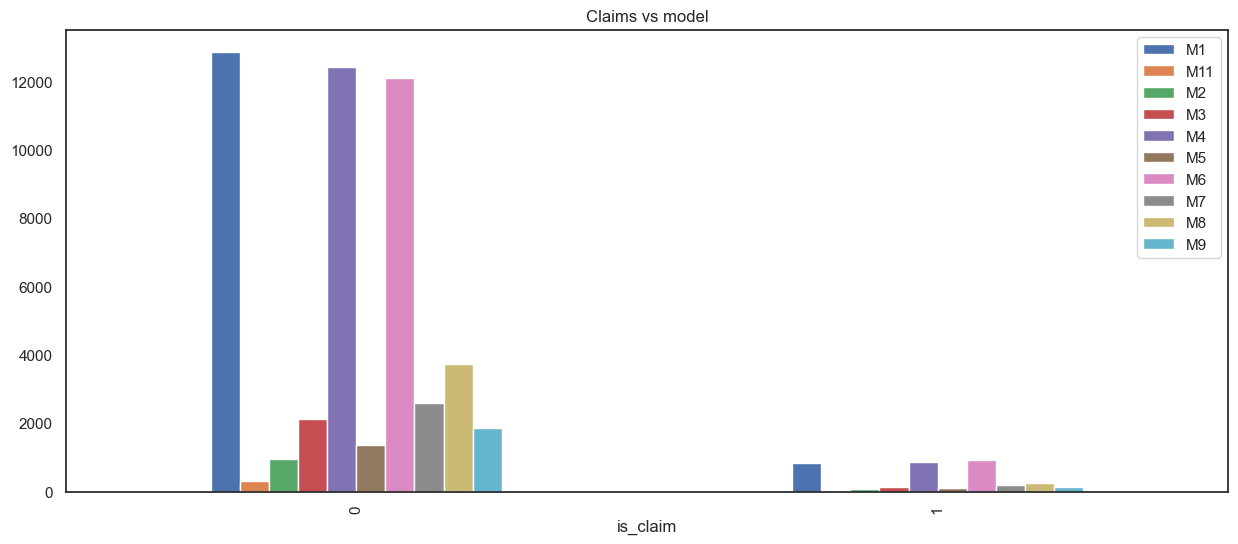

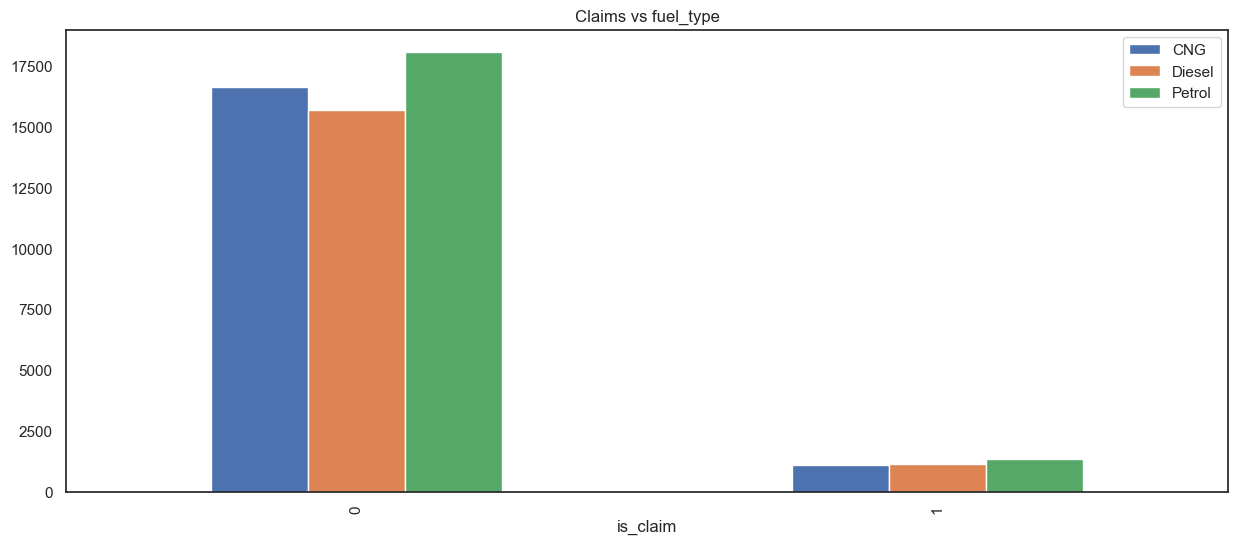

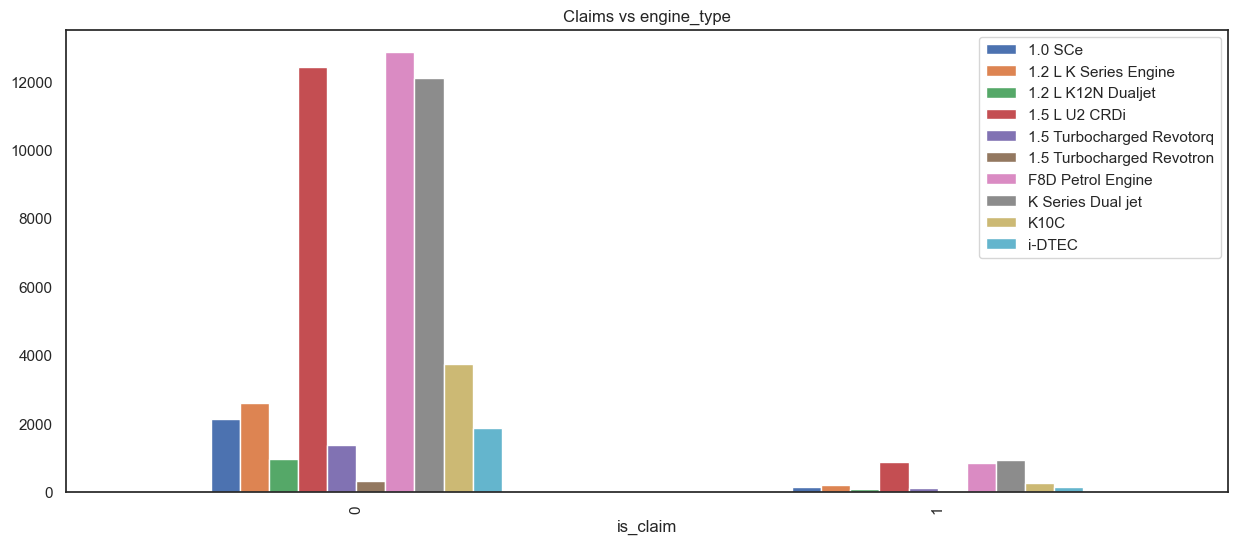

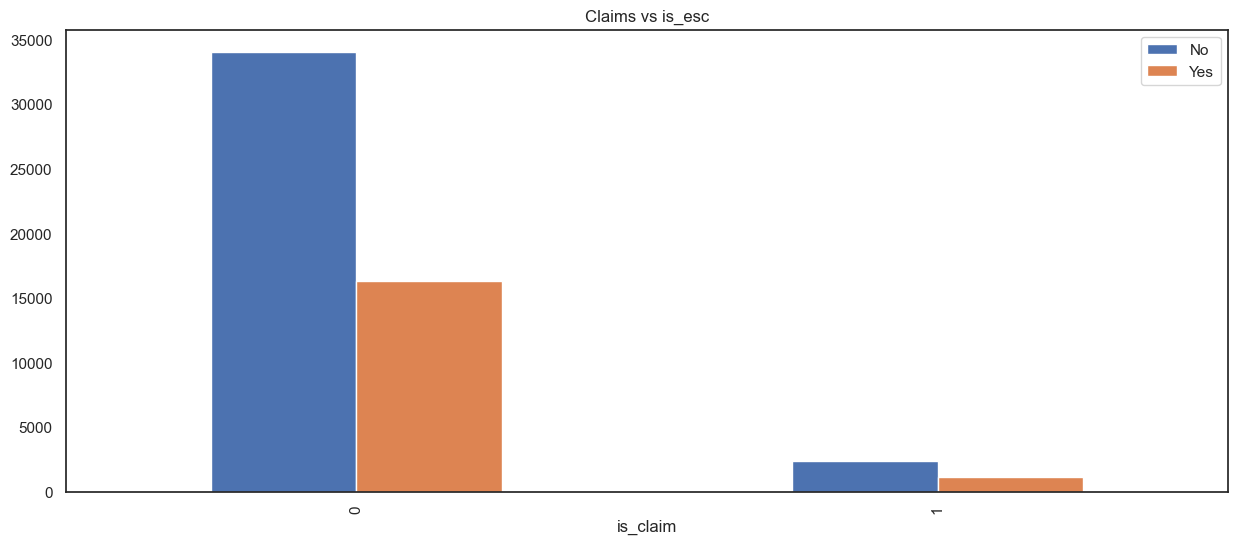

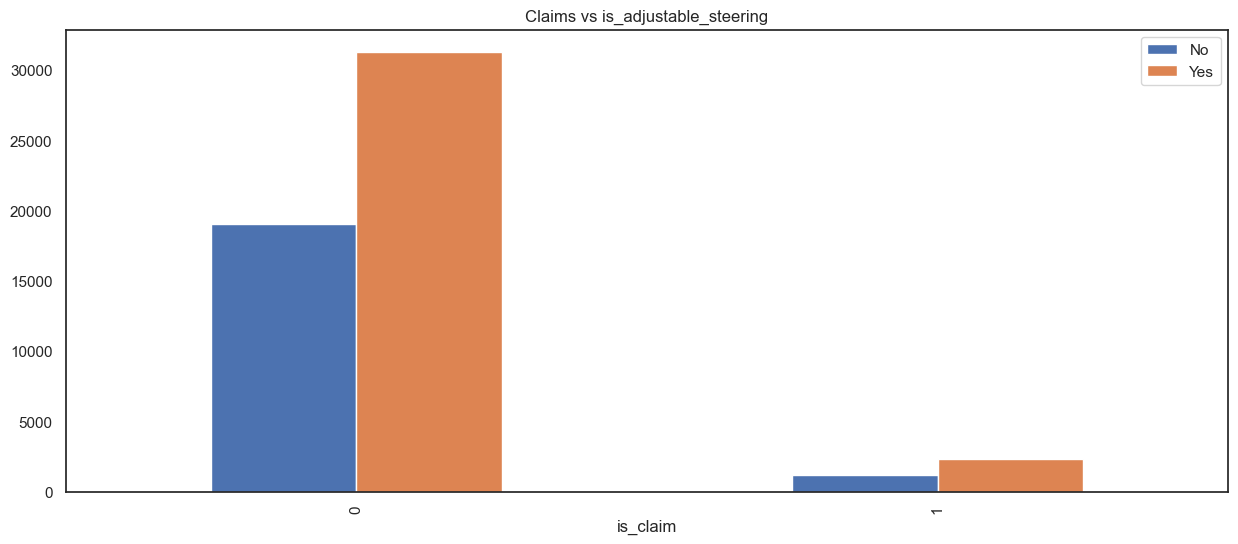

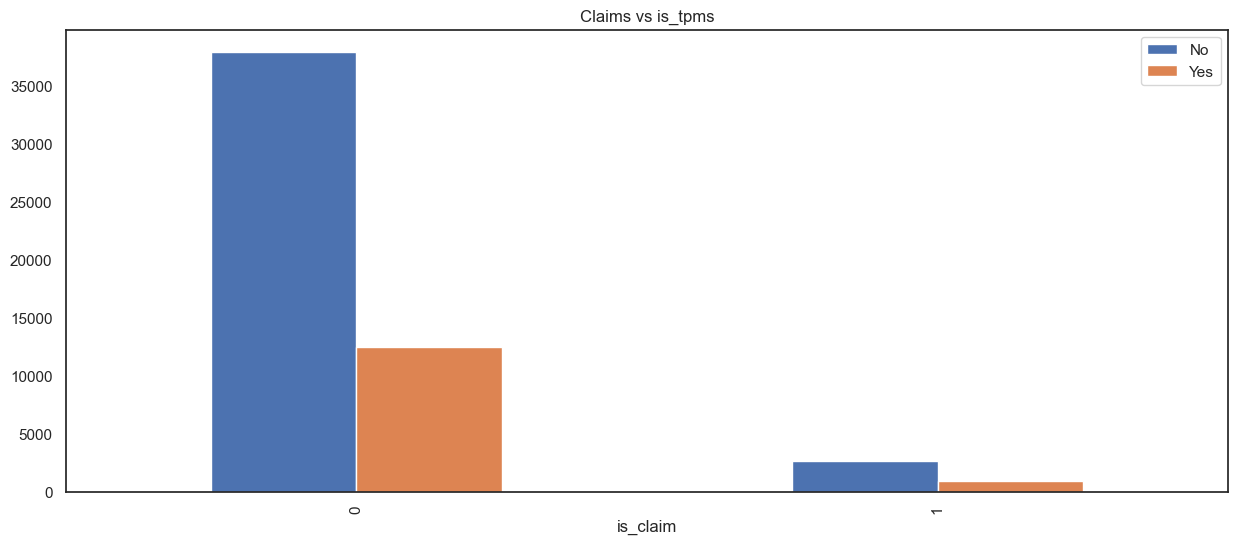

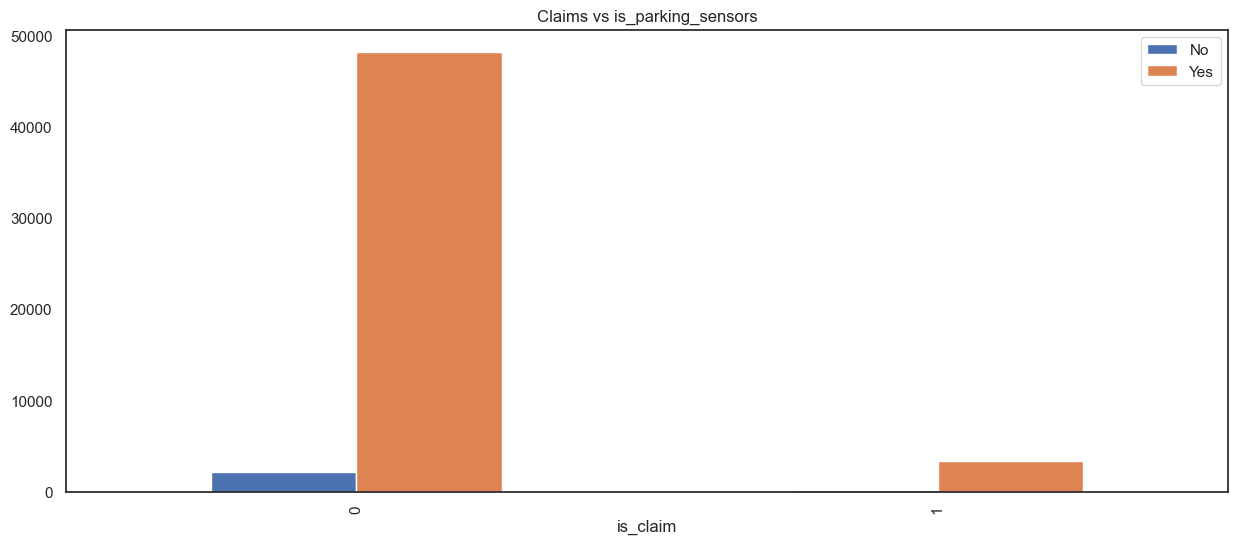

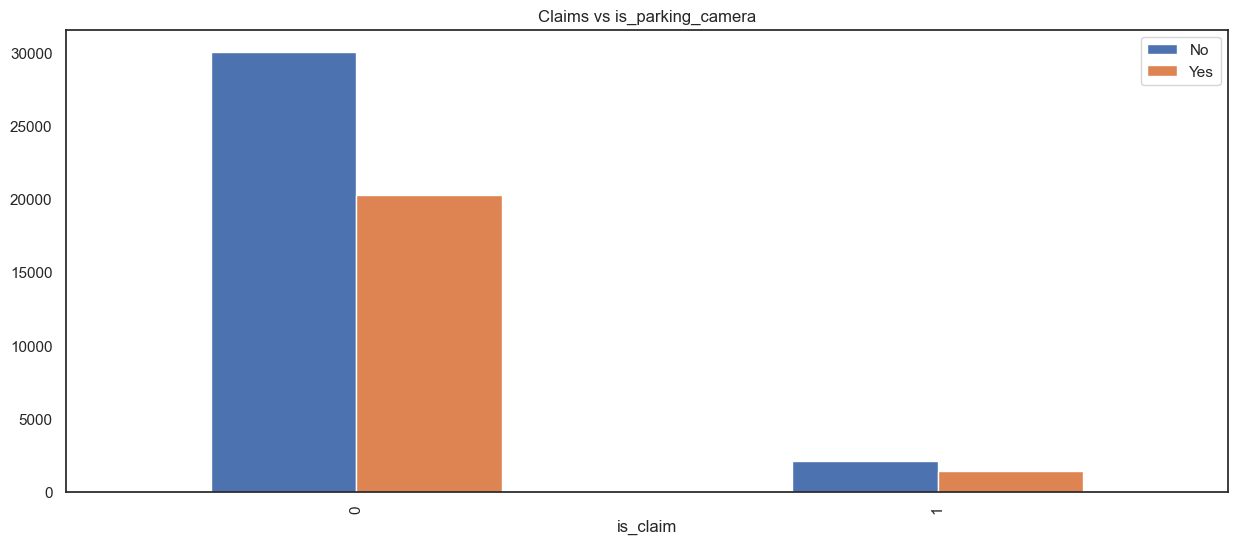

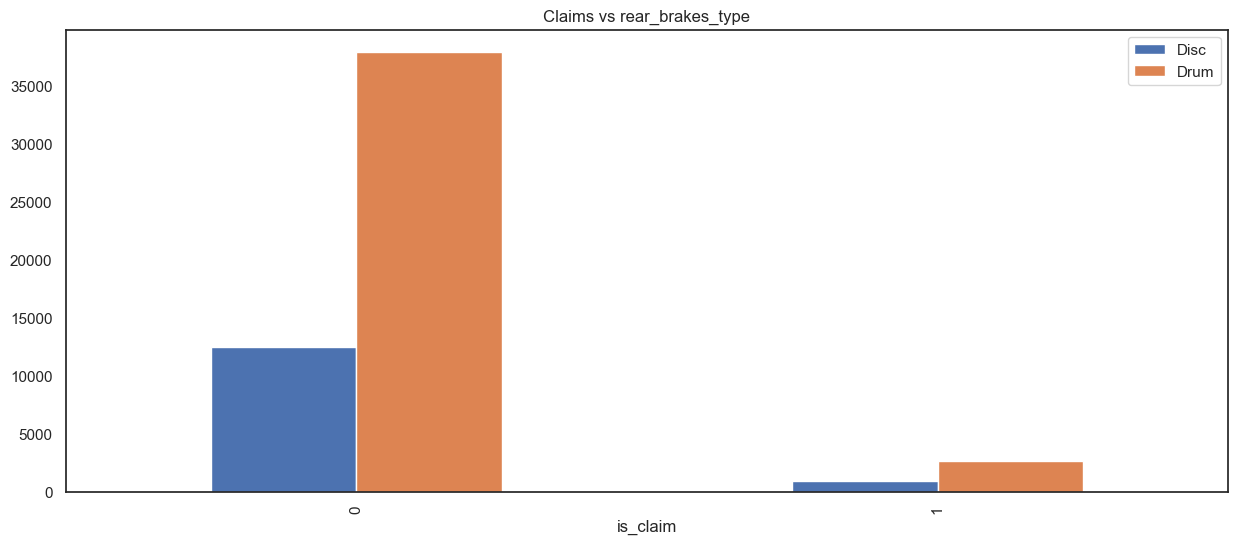

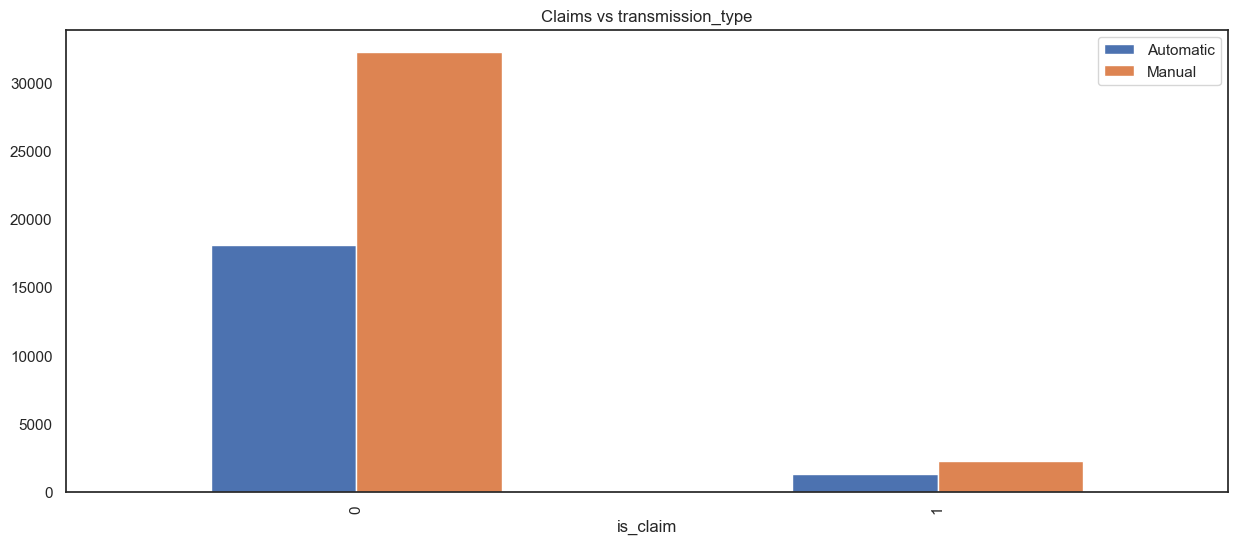

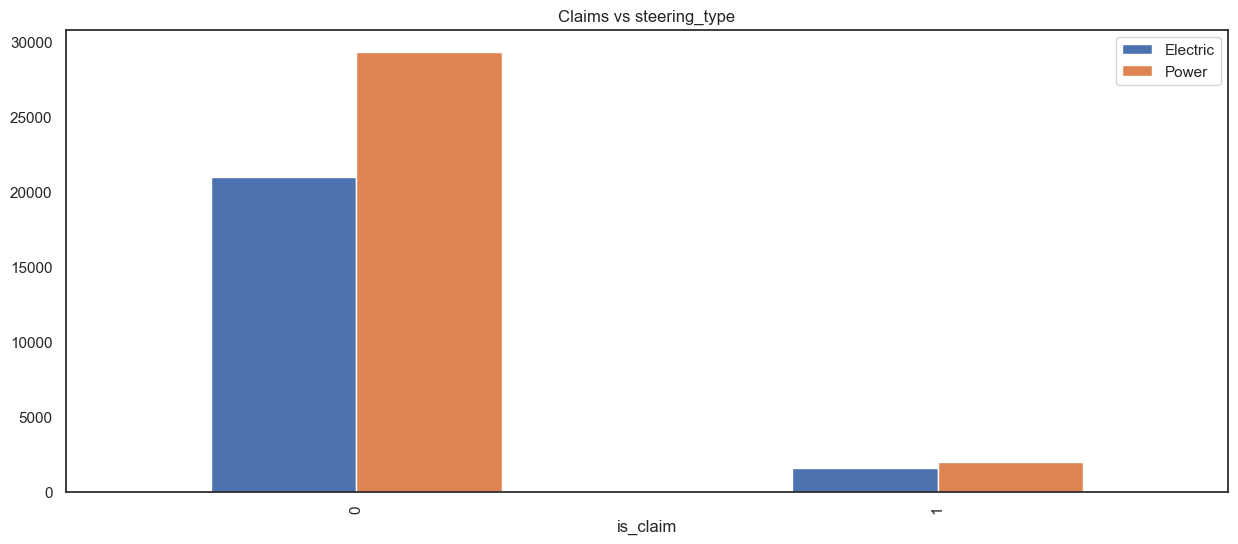

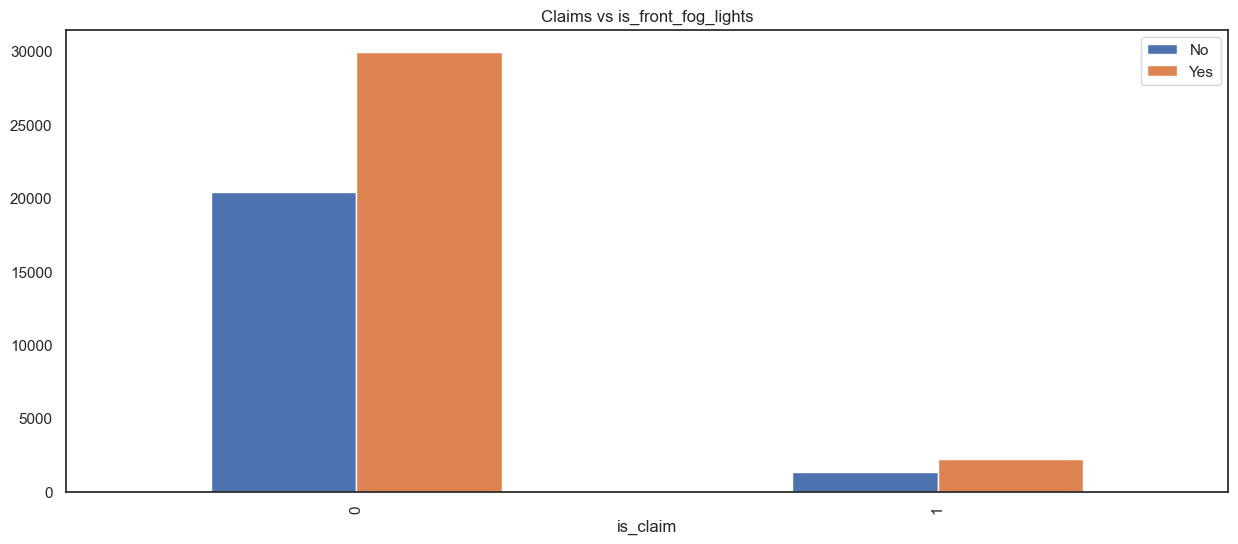

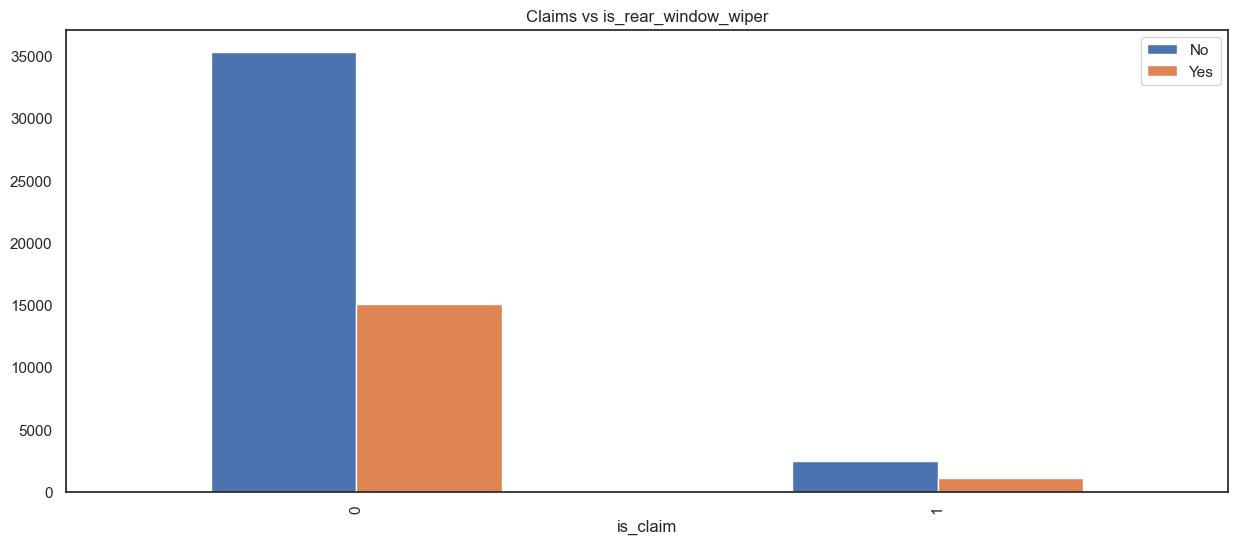

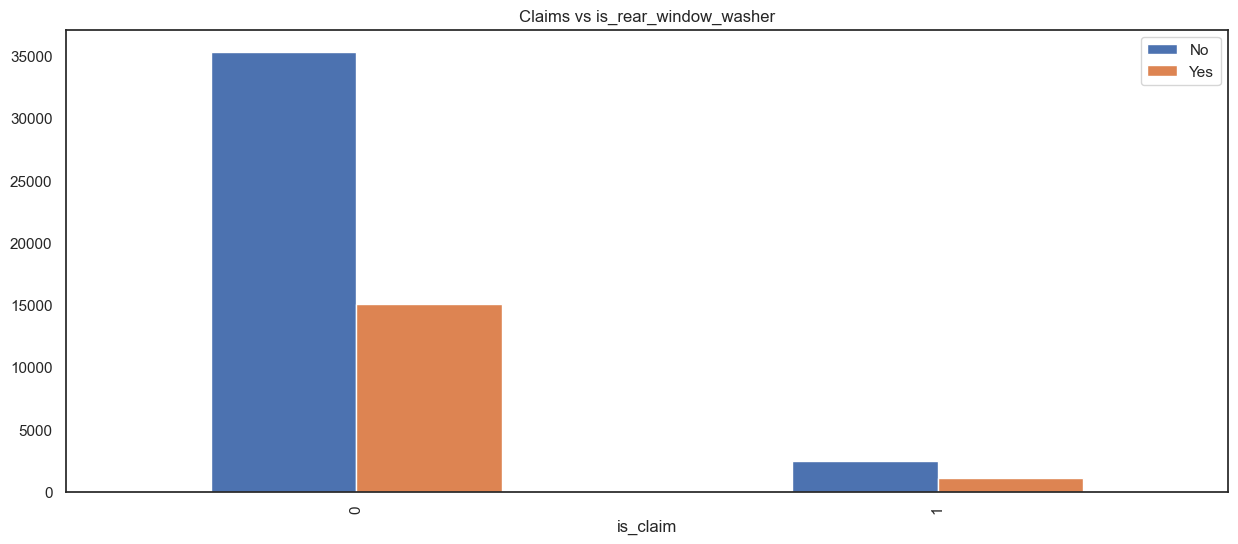

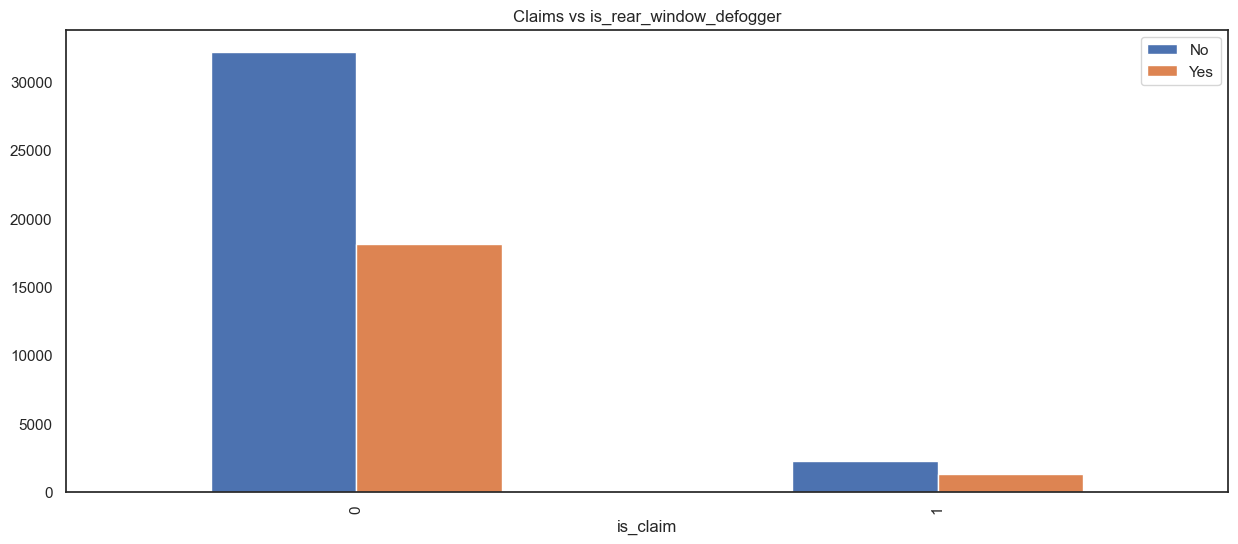

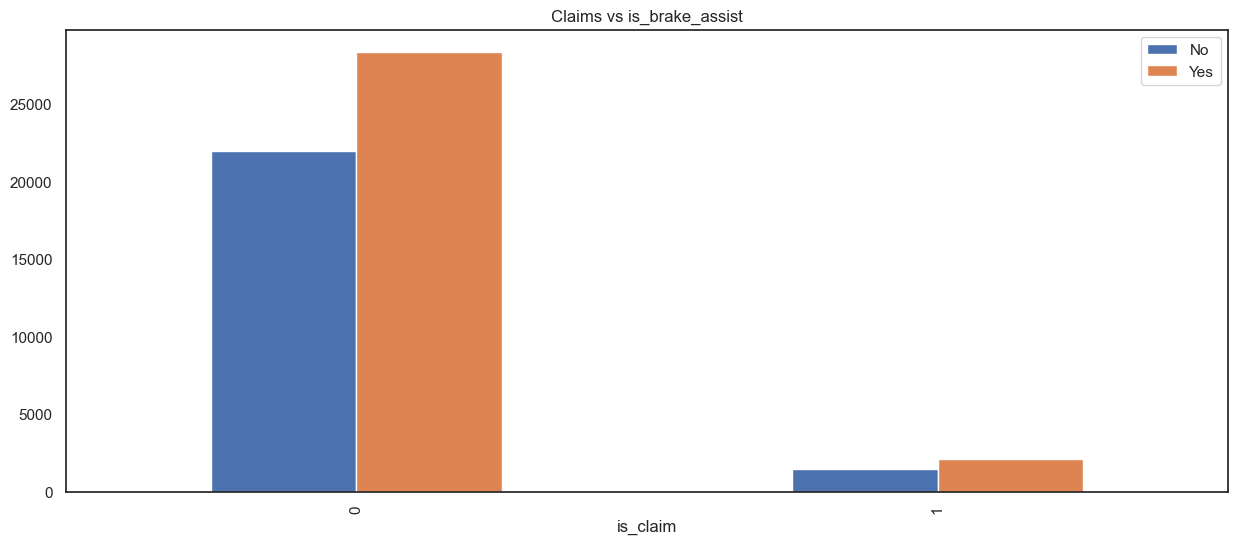

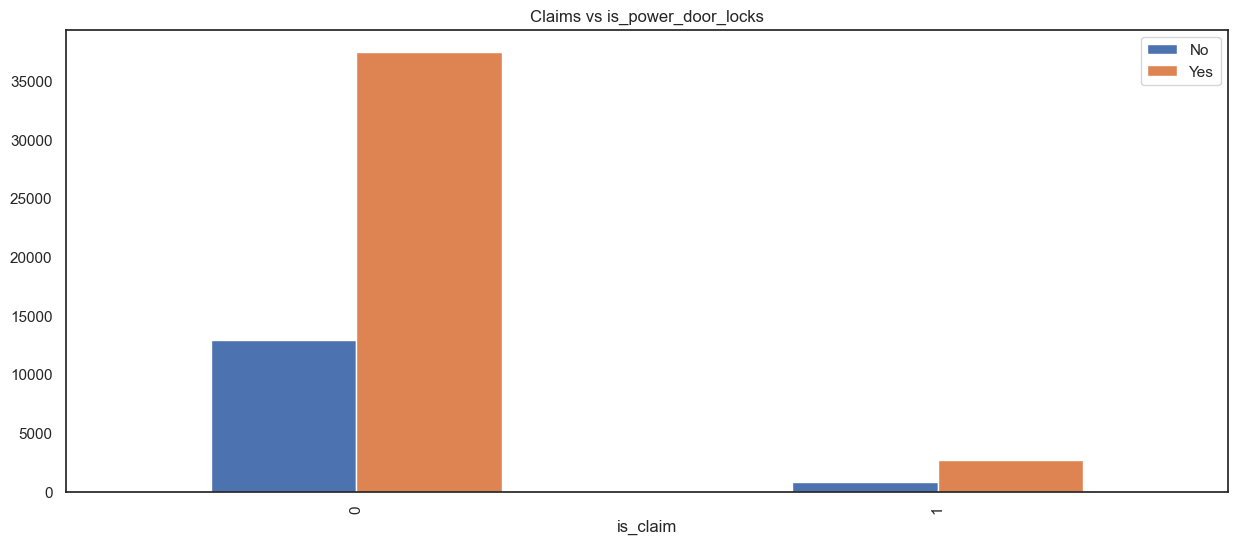

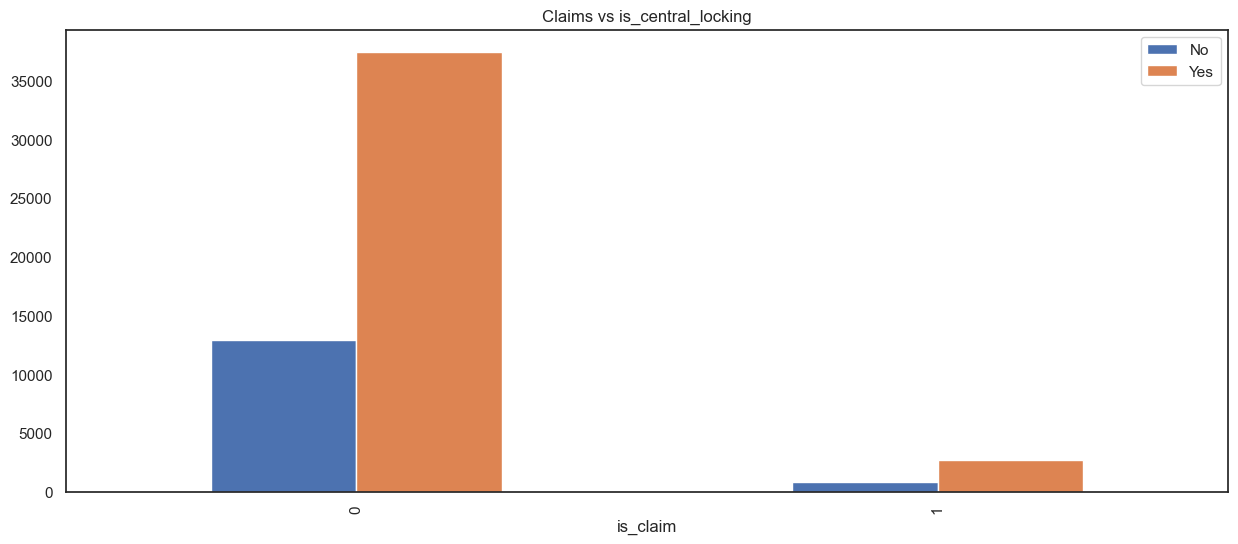

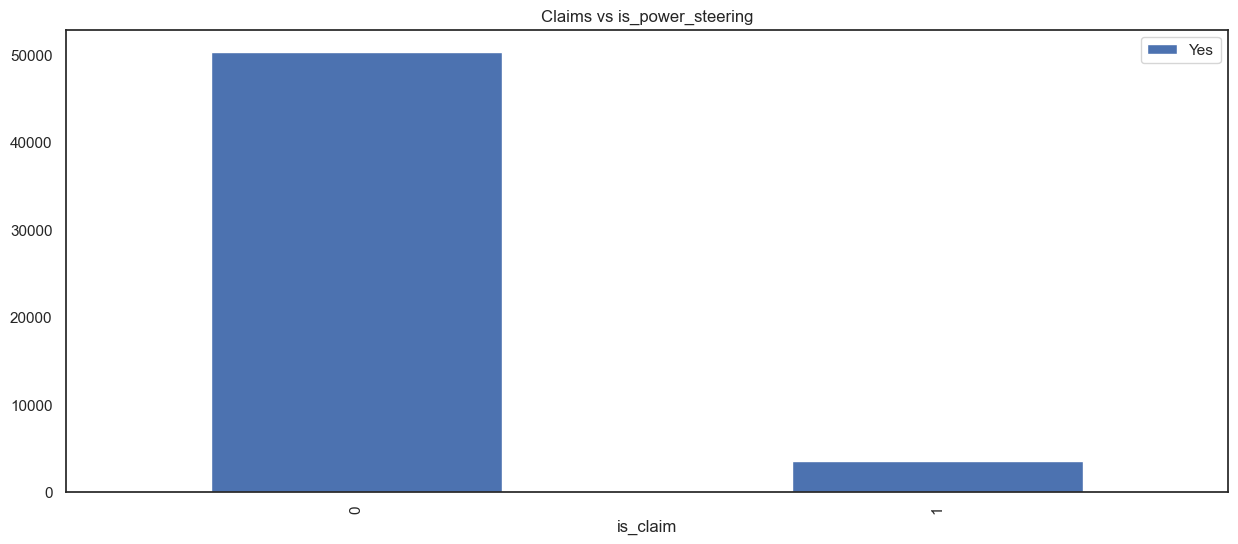

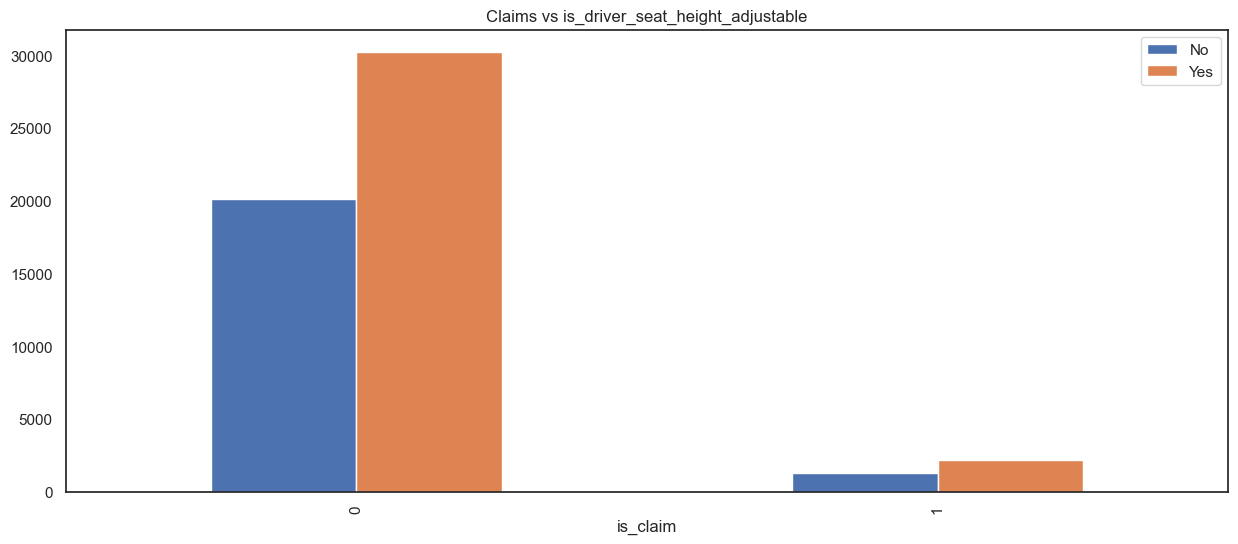

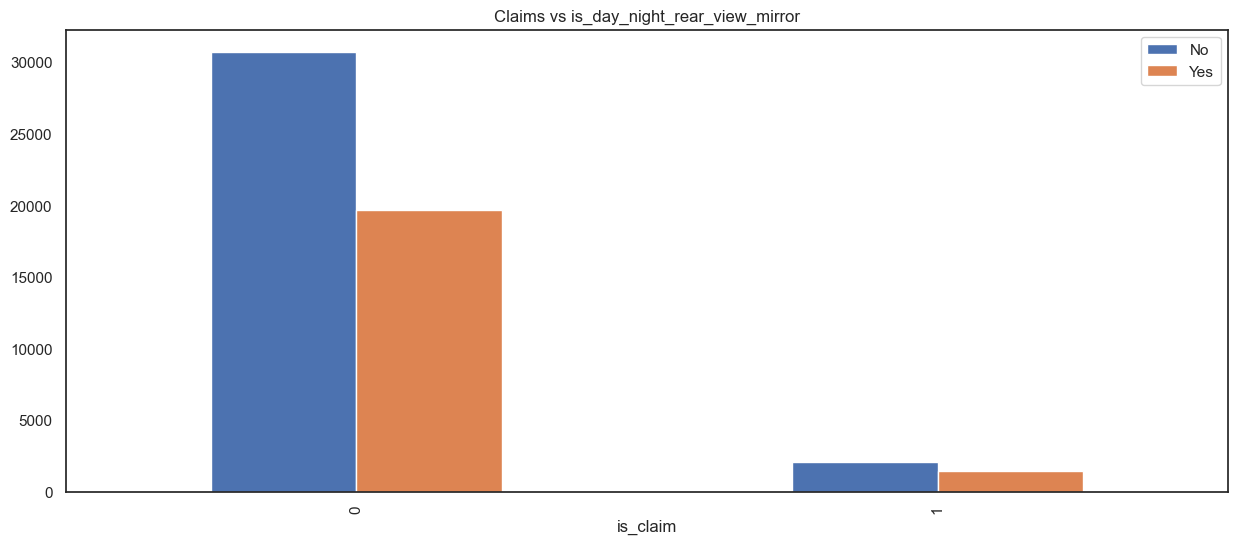

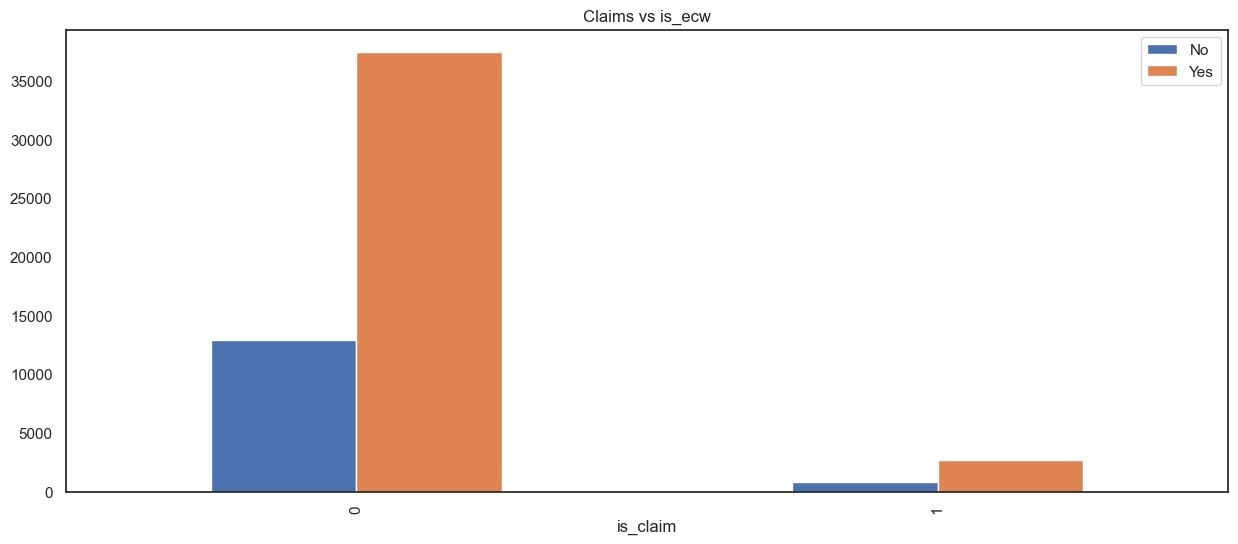

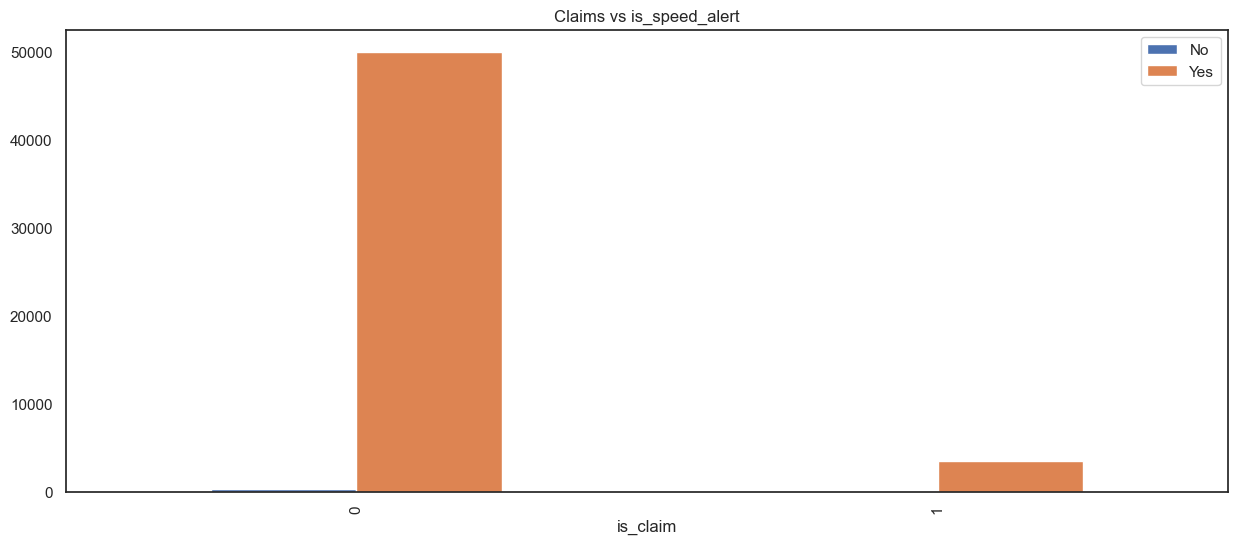

In [22]:
for cols in df_cat.columns:
    bar_charts(df,cols)

1. Cluster C19 appears to have a lot more people who did not claim any car insurance.
2. A lot more manual cars appear to not claim car insurance.
3. Cars in segment A, B2 and C2 have a lower tendency to claim car insurance.

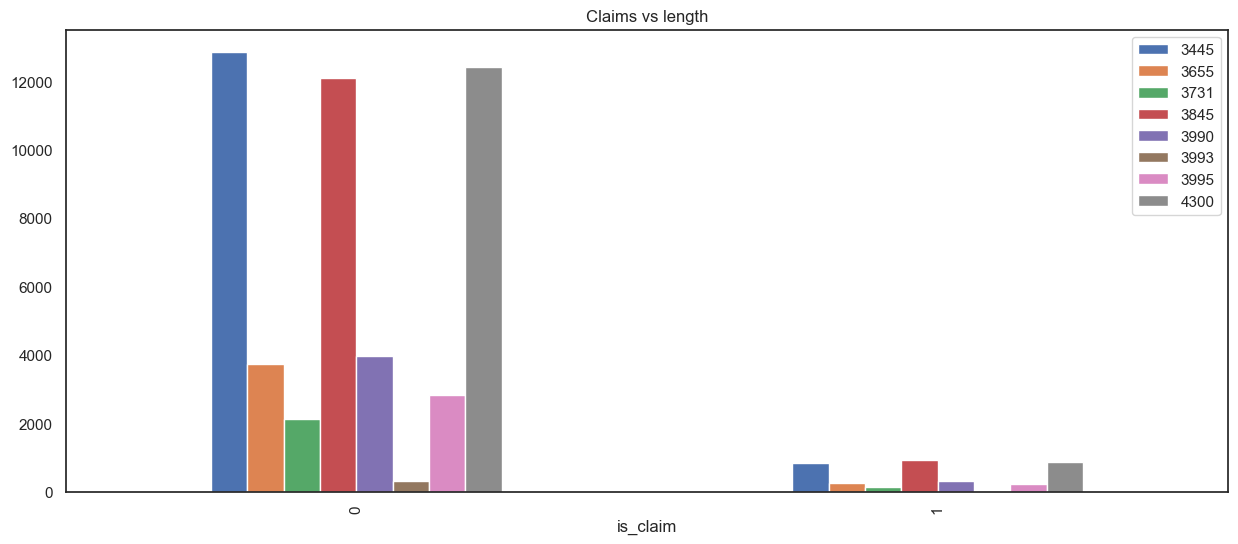

In [23]:
bar_charts(df,"length")

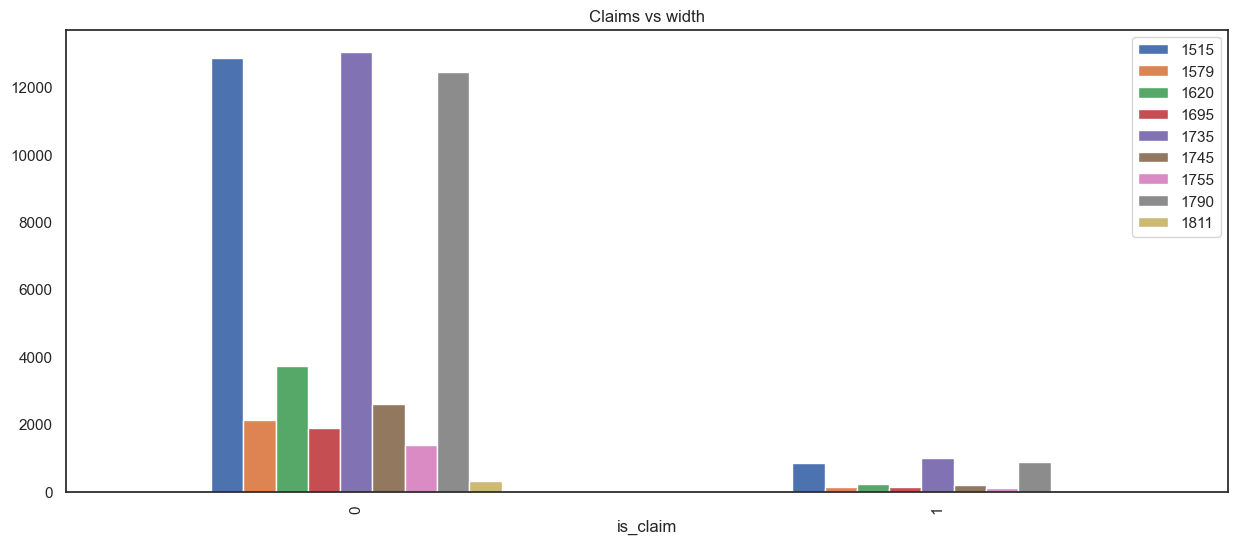

In [24]:
bar_charts(df,"width")

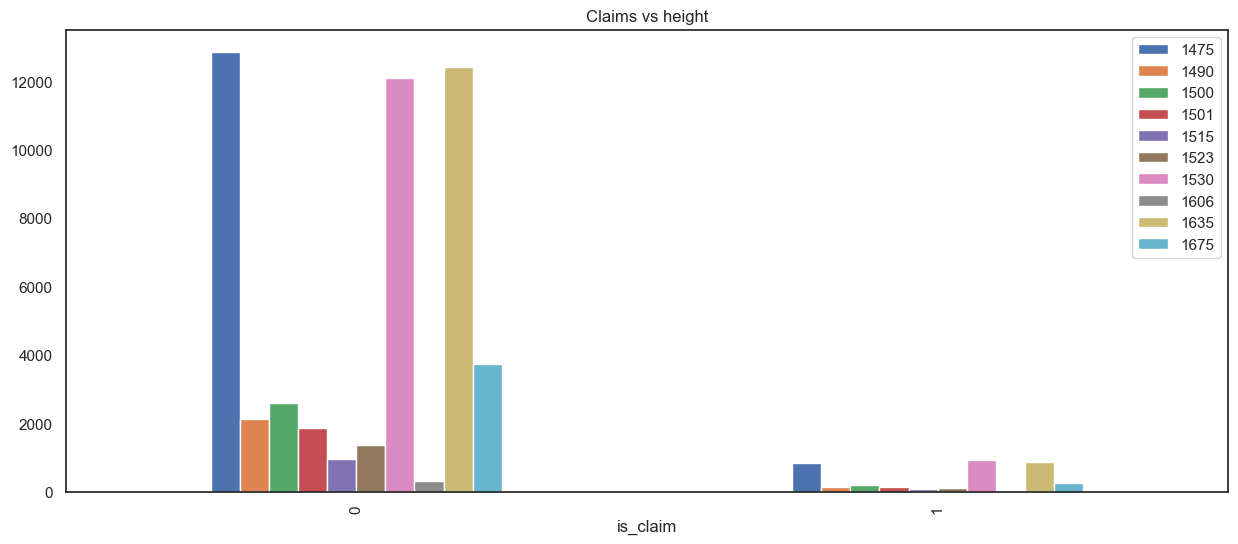

In [25]:
bar_charts(df,"height")

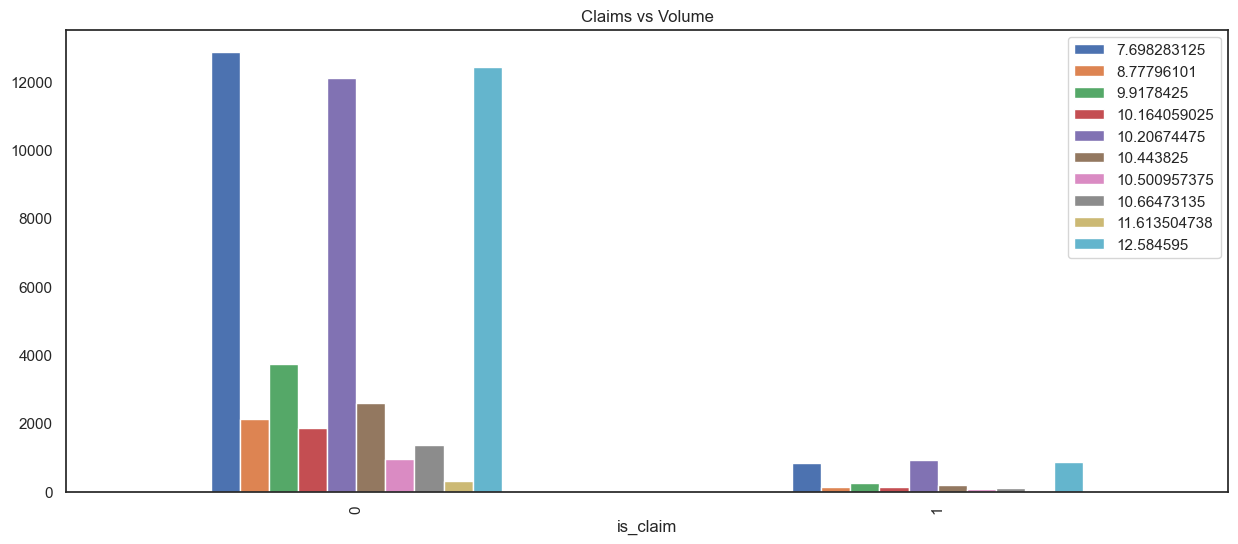

In [26]:
df["Volume"]=(df["height"]*df["width"]*df["length"])/(1000**3)
bar_charts(df,"Volume")

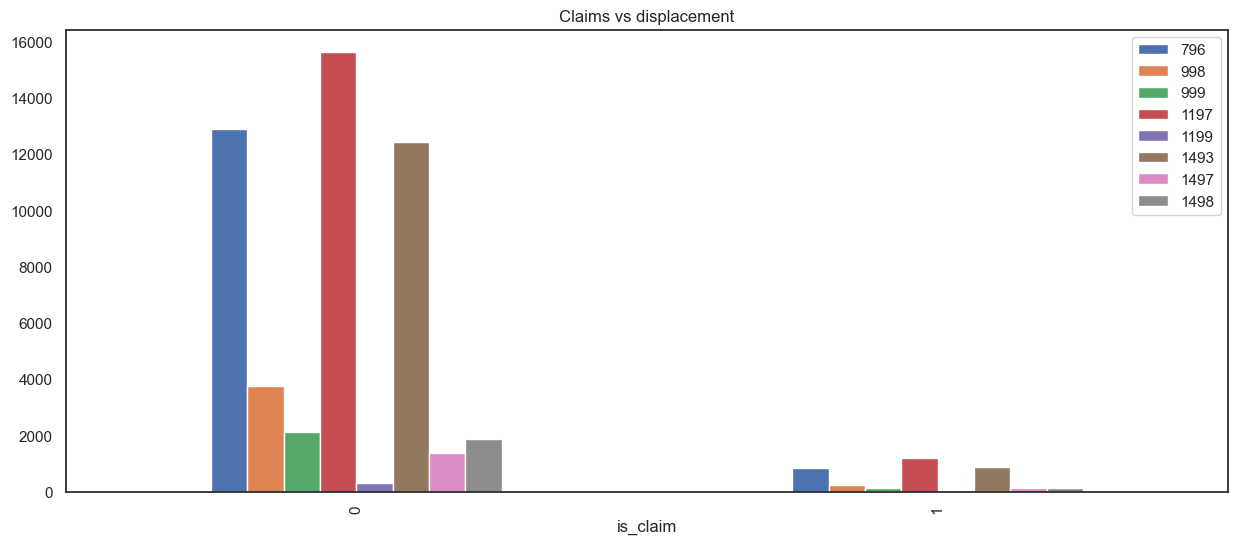

In [27]:
bar_charts(df,"displacement")

The smallest cc and smaller-sized cars appear to claim less insurance.

In [28]:
df.drop("Volume",axis=1,inplace=True)

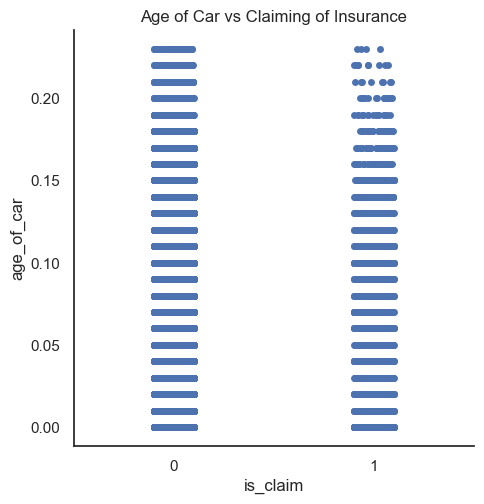

In [29]:
sns.catplot(x=df["is_claim"],y=df["age_of_car"])
plt.title("Age of Car vs Claiming of Insurance")
plt.show()

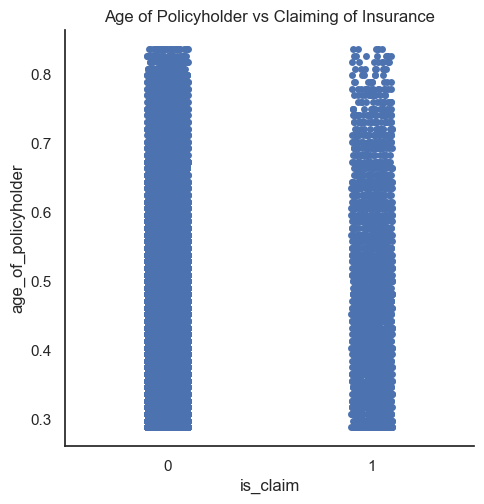

In [30]:
sns.catplot(x=df["is_claim"],y=df["age_of_policyholder"])
plt.title("Age of Policyholder vs Claiming of Insurance")
plt.show()

# Data Modelling

## Data preprocessing (Scaling and Encoding)

In [31]:
##Extracting numerical columns and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols=df.select_dtypes(numerics)
cat_cols=df.select_dtypes(exclude=numerics)

In [32]:
##make and ncap_rating are more categorical in nature, not numerical
cat_cols[["make","ncap_rating"]]=df[["make","ncap_rating"]]

In [33]:
cat_cols

,area_cluster,segment,model,fuel_type,engine_type,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,make,ncap_rating
0,C1,A,M1,CNG,F8D Petrol Engine,No,No,No,Yes,No,...,No,No,No,Yes,No,No,No,Yes,1,0
1,C2,A,M1,CNG,F8D Petrol Engine,No,No,No,Yes,No,...,No,No,No,Yes,No,No,No,Yes,1,0
2,C3,A,M1,CNG,F8D Petrol Engine,No,No,No,Yes,No,...,No,No,No,Yes,No,No,No,Yes,1,0
3,C4,C1,M2,Petrol,1.2 L K12N Dualjet,Yes,Yes,No,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1,2
4,C5,A,M3,Petrol,1.0 SCe,No,No,No,No,Yes,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,C8,A,M3,Petrol,1.0 SCe,No,No,No,No,Yes,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,2
58588,C14,A,M1,CNG,F8D Petrol Engine,No,No,No,Yes,No,...,No,No,No,Yes,No,No,No,Yes,1,0
58589,C5,A,M1,CNG,F8D Petrol Engine,No,No,No,Yes,No,...,No,No,No,Yes,No,No,No,Yes,1,0
58590,C8,B2,M6,Petrol,K Series Dual jet,No,Yes,No,Yes,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1,2


In [34]:
num_cols.drop(["ncap_rating","make","is_claim"],axis=1,inplace=True)

In [35]:
num_cols.columns

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'airbags', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'max_torque_Nm', 'max_torque_rpm', 'max_power_bp', 'max_power_rpm'],
      dtype='object')

In [36]:
##One-Hot Encoding for categorical columns
df_cat=pd.get_dummies(cat_cols)

In [37]:
df_cat

,make,ncap_rating,area_cluster_C1,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,...,is_central_locking_Yes,is_power_steering_Yes,is_driver_seat_height_adjustable_No,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_No,is_day_night_rear_view_mirror_Yes,is_ecw_No,is_ecw_Yes,is_speed_alert_No,is_speed_alert_Yes
0,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
3,1,2,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1
4,2,2,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,2,2,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,1,0,1
58588,1,0,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,1,0,0,1
58589,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
58590,1,2,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1


In [38]:
#polynomial features, feature selection, standardise based on min-max scaler,
#check for outliers, remove outliers, GridSearchCV (hyperparameter optimisation), resample, take 5000 eg.

In [39]:
##Putting one-hot encoded data back together in one dataframe
df2=pd.concat([df.drop(columns=cat_cols),df_cat],axis=1)

In [40]:
##Setting target and feature variables
X=df2.drop("is_claim",axis=1)
y=df2["is_claim"]

In [41]:
X.shape

(53865, 107)

In [42]:
##Train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25,stratify=y)

In [43]:
##Scaling numerical data
scaler=MinMaxScaler()
X_train[num_cols.columns]=scaler.fit_transform(X_train[num_cols.columns])
X_test[num_cols.columns]=scaler.transform(X_test[num_cols.columns])

In [44]:
##SMOTE-ENN to make up for imbalanced dataset
smote=SMOTEENN(random_state=42)
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

## Logistic Regression

In [45]:
lr=LogisticRegression()
lr.fit(X_train_smote,y_train_smote)

LogisticRegression()

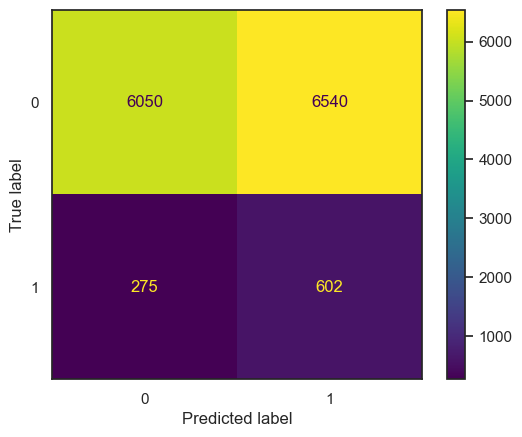

              precision    recall  f1-score   support

           0       0.96      0.48      0.64     12590
           1       0.08      0.69      0.15       877

    accuracy                           0.49     13467
   macro avg       0.52      0.58      0.39     13467
weighted avg       0.90      0.49      0.61     13467



In [46]:
y_pred=lr.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()
print(classification_report(y_test,y_pred))

## Decision Tree

In [47]:
dt=DecisionTreeClassifier()
dt.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier()

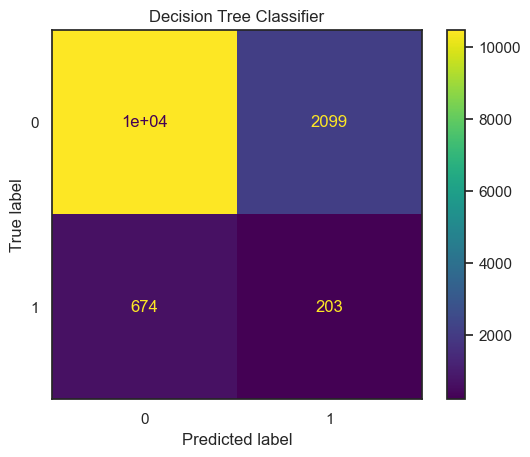

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     12590
           1       0.09      0.23      0.13       877

    accuracy                           0.79     13467
   macro avg       0.51      0.53      0.51     13467
weighted avg       0.88      0.79      0.83     13467



In [48]:
y2_pred=dt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y2_pred)
plt.title("Decision Tree Classifier")
plt.show()
print(classification_report(y_test,y2_pred))

## Support Vector Machine


In [49]:
svm=svm.SVC()
svm.fit(X_train_smote,y_train_smote)

SVC()

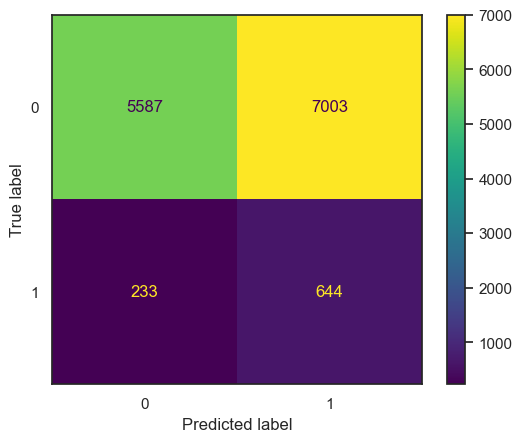

              precision    recall  f1-score   support

           0       0.96      0.44      0.61     12590
           1       0.08      0.73      0.15       877

    accuracy                           0.46     13467
   macro avg       0.52      0.59      0.38     13467
weighted avg       0.90      0.46      0.58     13467



In [50]:
y_pred_svm=svm.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_svm)
plt.show()
print(classification_report(y_test,y_pred_svm))

## Random Forest

In [51]:
rf=RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)

RandomForestClassifier()

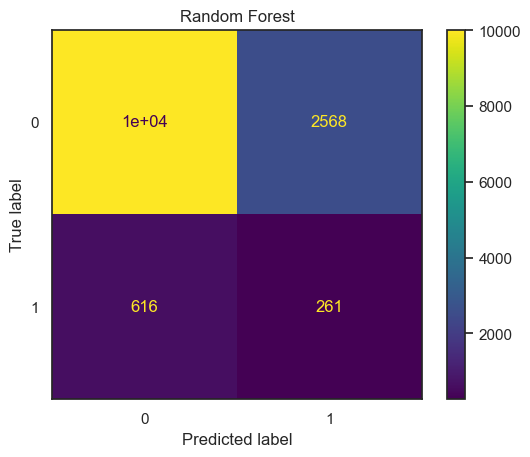

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     12590
           1       0.09      0.30      0.14       877

    accuracy                           0.76     13467
   macro avg       0.52      0.55      0.50     13467
weighted avg       0.89      0.76      0.82     13467



In [52]:
y3_pred=rf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y3_pred)
plt.title("Random Forest")
plt.show()
print(classification_report(y_test,y3_pred))

## PCA

In [53]:
pca=PCA(n_components=10)
X_train_pca=pca.fit_transform(X_train_smote)
X_test_pca=pca.transform(X_test)

In [54]:
print(pca.explained_variance_ratio_)
np.sum(pca.explained_variance_ratio_[0:10])

[0.48373062 0.20616075 0.11261957 0.04769957 0.03895534 0.02059696
 0.01480793 0.01221186 0.00918761 0.00778369]


0.9537539009308936

In [55]:
##Random Forest + PCA
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_pca,y_train_smote)

RandomForestClassifier()

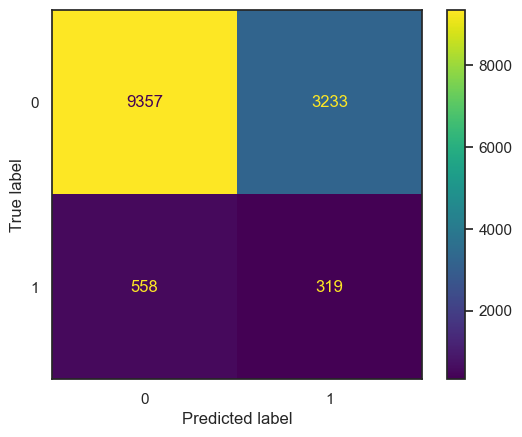

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     12590
           1       0.09      0.36      0.14       877

    accuracy                           0.72     13467
   macro avg       0.52      0.55      0.49     13467
weighted avg       0.89      0.72      0.79     13467



In [56]:
y_pred_pca=rf_pca.predict(X_test_pca)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_pca)
plt.show()
print(classification_report(y_test,y_pred_pca))

## Polynomial Features

In [57]:
##Trying polynomial features
poly=PolynomialFeatures(2)
X_train_poly=poly.fit_transform(X_train_smote)
X_test_poly=poly.transform(X_test)

In [58]:
rf_poly=RandomForestClassifier()
rf_poly.fit(X_train_poly,y_train_smote)

RandomForestClassifier()

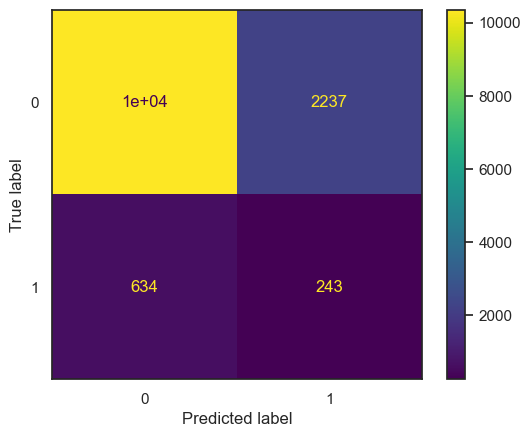

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     12590
           1       0.10      0.28      0.14       877

    accuracy                           0.79     13467
   macro avg       0.52      0.55      0.51     13467
weighted avg       0.89      0.79      0.83     13467



In [59]:
y_pred_poly=rf_poly.predict(X_test_poly)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_poly)
plt.show()
print(classification_report(y_test,y_pred_poly))

In [60]:
##SelectKbest with polynomial features
selector=SelectKBest(chi2,k=25)
X_train_selected=selector.fit_transform(X_train_poly,y_train_smote)
X_test_selected=selector.transform(X_test_poly)

In [61]:
rf_polykbest=RandomForestClassifier()
rf_polykbest.fit(X_train_selected,y_train_smote)

RandomForestClassifier()

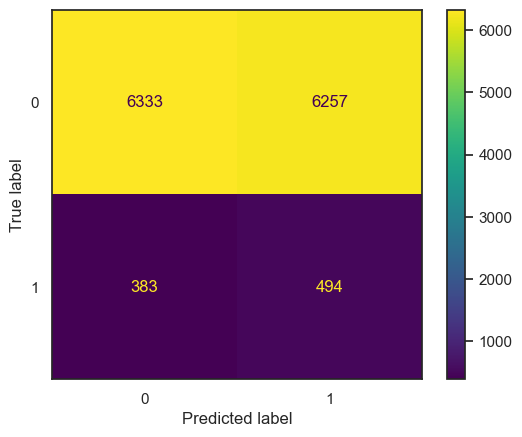

              precision    recall  f1-score   support

           0       0.94      0.50      0.66     12590
           1       0.07      0.56      0.13       877

    accuracy                           0.51     13467
   macro avg       0.51      0.53      0.39     13467
weighted avg       0.89      0.51      0.62     13467



In [62]:
y_pred_polykbest=rf_polykbest.predict(X_test_selected)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_polykbest)
plt.show()
print(classification_report(y_test,y_pred_polykbest))

In [63]:
##PCA with polynomial features
pca=PCA()
X_train_polypca=pca.fit_transform(X_train_poly)
X_test_polypca=pca.transform(X_test_poly)

In [64]:
rf_polypca=RandomForestClassifier()
rf_polypca.fit(X_train_polypca,y_train_smote)

RandomForestClassifier()

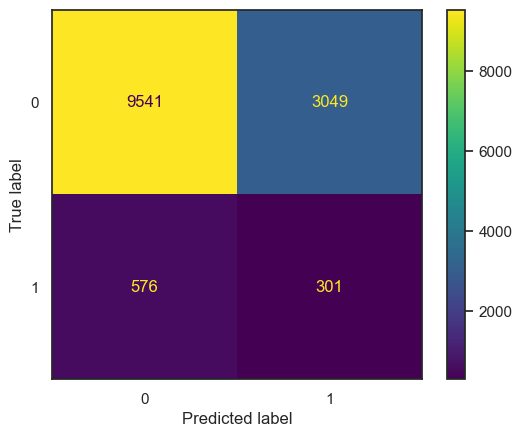

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     12590
           1       0.09      0.34      0.14       877

    accuracy                           0.73     13467
   macro avg       0.52      0.55      0.49     13467
weighted avg       0.89      0.73      0.79     13467



In [65]:
y_pred_polypca=rf_polypca.predict(X_test_polypca)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_polypca)
plt.show()
print(classification_report(y_test,y_pred_polypca))

## Feature Selection

In [66]:
##K-Best - Selecting top 25 best features
selector=SelectKBest(chi2,k=25)
X_train_selected=selector.fit_transform(X_train_smote,y_train_smote)
X_test_selected=selector.transform(X_test)

In [67]:
rf_selected=RandomForestClassifier()
rf_selected.fit(X_train_selected,y_train_smote)

RandomForestClassifier()

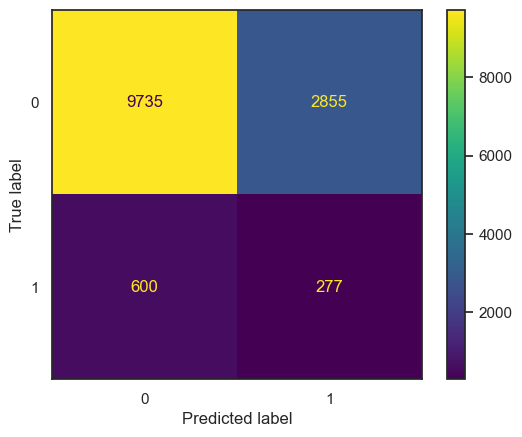

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     12590
           1       0.09      0.32      0.14       877

    accuracy                           0.74     13467
   macro avg       0.52      0.54      0.49     13467
weighted avg       0.89      0.74      0.80     13467



In [68]:
y_pred_sel=rf_selected.predict(X_test_selected)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_sel)
plt.show()
print(classification_report(y_test,y_pred_sel))

In [69]:
##Forward Feature Selection
rf_ff=LogisticRegression()
sfs=SequentialFeatureSelector(rf_ff,n_features_to_select=10,direction="forward")
X_train_ff=sfs.fit_transform(X_train_smote,y_train_smote)
X_test_ff=sfs.transform(X_test)

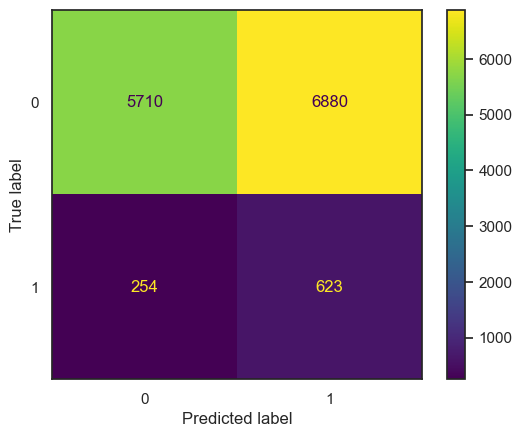

              precision    recall  f1-score   support

           0       0.96      0.45      0.62     12590
           1       0.08      0.71      0.15       877

    accuracy                           0.47     13467
   macro avg       0.52      0.58      0.38     13467
weighted avg       0.90      0.47      0.59     13467



In [70]:
rf_ff.fit(X_train_ff,y_train_smote)
y_pred_ff=rf_ff.predict(X_test_ff)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_ff)
plt.show()
print(classification_report(y_test,y_pred_ff))

## Boosting

In [71]:
xgbmodel=xgb.XGBClassifier(gamma=0.1,learning_rate=0.3,n_estimators=150)
xgbmodel.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

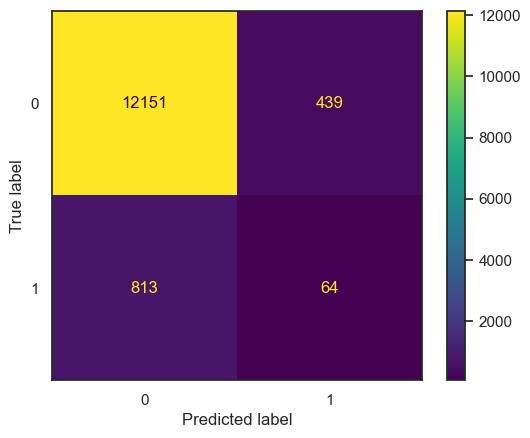

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     12590
           1       0.13      0.07      0.09       877

    accuracy                           0.91     13467
   macro avg       0.53      0.52      0.52     13467
weighted avg       0.88      0.91      0.90     13467



In [72]:
y_pred_xgb=xgbmodel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb)
plt.show()
print(classification_report(y_test,y_pred_xgb))

In [73]:
##XGBoost with SelectKbest
xgbmodel_features=xgb.XGBClassifier()
xgbmodel_features.fit(X_train_selected,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

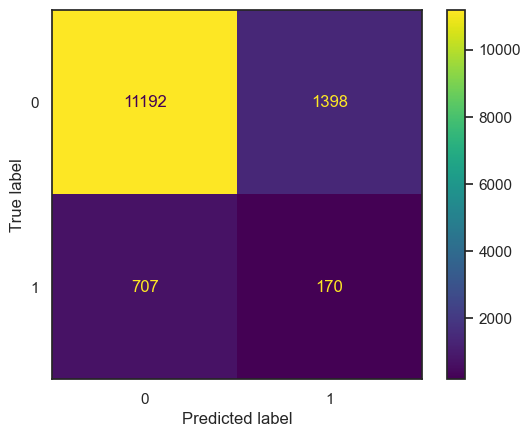

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     12590
           1       0.11      0.19      0.14       877

    accuracy                           0.84     13467
   macro avg       0.52      0.54      0.53     13467
weighted avg       0.89      0.84      0.86     13467



In [74]:
y_pred_xgb_kbest=xgbmodel_features.predict(X_test_selected)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb_kbest)
plt.show()
print(classification_report(y_test,y_pred_xgb_kbest))

In [75]:
##XGBoost with PCA
xgb_pca=xgb.XGBClassifier()
xgb_pca.fit(X_train_pca,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

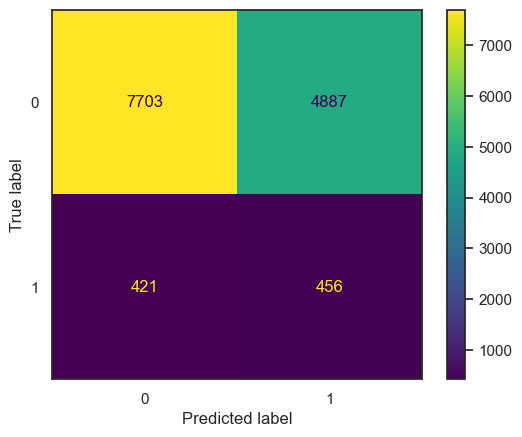

              precision    recall  f1-score   support

           0       0.95      0.61      0.74     12590
           1       0.09      0.52      0.15       877

    accuracy                           0.61     13467
   macro avg       0.52      0.57      0.45     13467
weighted avg       0.89      0.61      0.70     13467



In [76]:
y_pred_xgb_pca=xgb_pca.predict(X_test_pca)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb_pca)
plt.show()
print(classification_report(y_test,y_pred_xgb_pca))

## Stacking

In [77]:
rf_stack=RandomForestClassifier()
xgb_stack=xgb.XGBClassifier()
knn_stack=KNeighborsClassifier() ##SVM, or adaboost, f1 score below 0.30, threshold, show the whole transition from simple to ensemble, 
estimators=[('rf',rf_stack),('xgb',xgb_stack),('knn',knn_stack)]

In [78]:
stack_model=StackingClassifier(estimators=estimators,cv=10)
stack_model.fit(X_train_smote,y_train_smote)

StackingClassifier(cv=10,
                   estimators=[('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('knn', KNeighborsClassifier())])

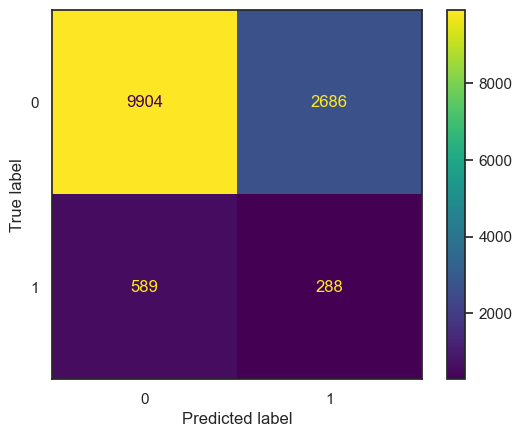

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     12590
           1       0.10      0.33      0.15       877

    accuracy                           0.76     13467
   macro avg       0.52      0.56      0.50     13467
weighted avg       0.89      0.76      0.81     13467



In [79]:
y_pred_stack=stack_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_stack)
plt.show()
print(classification_report(y_test,y_pred_stack))

## Neural Network

In [80]:
##to try neural network
model = Sequential()
n_cols=X_train_smote.shape[1]

In [81]:
model.add(Dense(100, activation = 'relu', input_shape = (n_cols, )))
# Add the second hidden layer
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(8,activation='relu'))
# Add the output layer
model.add(Dense(1, activation = 'sigmoid'))

In [82]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10800     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,017
Trainable params: 12,017
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
weight=class_weight.compute_class_weight('balanced', classes=np.unique(y_train),y=y_train)
weight_dict = dict(enumerate(weight))

In [84]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['SparseCategoricalAccuracy'])

In [85]:
history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_split = 0.25,
    batch_size = 250,
    epochs = 100,
    verbose = 1)

Epoch 1/100
158/158 [==============================] - 3s 4ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.9478 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 0.6250 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.9183 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 0.6053 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.7755 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 

158/158 [==============================] - 0s 2ms/step - loss: 0.4667 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.6447 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 46/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4655 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.6014 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 47/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4635 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5605 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 48/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4629 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.4546 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 49/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4612 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5829 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 50/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4623 

158/158 [==============================] - 0s 2ms/step - loss: 0.4290 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 90/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5110 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 91/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4248 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 92/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4262 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.5144 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 93/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4280 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.6996 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 94/100
158/158 [==============================] - 0s 2ms/step - loss: 0.4248 

In [86]:
y_pred_nn=(model.predict(X_test) > 0.5).astype("int32")

421/421 [==============================] - 1s 817us/step


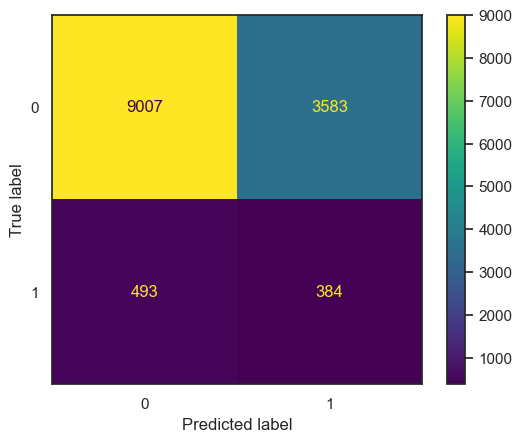

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     12590
           1       0.10      0.44      0.16       877

    accuracy                           0.70     13467
   macro avg       0.52      0.58      0.49     13467
weighted avg       0.89      0.70      0.77     13467



In [87]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_nn)
plt.show()
print(classification_report(y_test,y_pred_nn))

## AUC

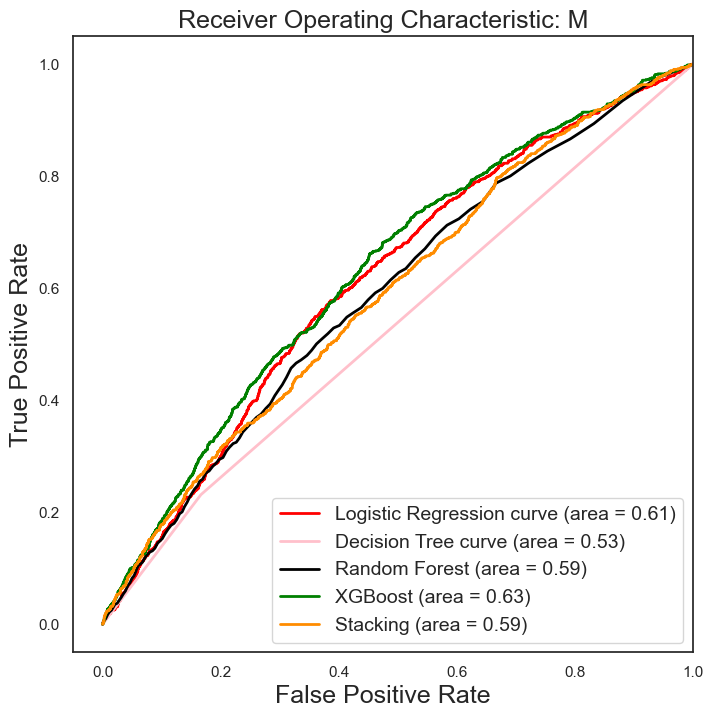

In [88]:
#Plotting the AUC (Area under the ROC Curve/ROC (Receiver Operating Characteristic) to compare across
lr_preds=lr.predict_proba(X_test)[:,1]
fpr,tpr,_=metrics.roc_curve(y_test,lr_preds)
roc_auc=metrics.auc(fpr,tpr)

dt_preds=dt.predict_proba(X_test)[:,1]
fpr2,tpr2,_=metrics.roc_curve(y_test,dt_preds)
roc_auc2=metrics.auc(fpr2,tpr2)

rf_preds = rf.predict_proba(X_test)[:,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test, rf_preds)
roc_auc3 = metrics.auc(fpr3, tpr3)

xgb_preds = xgbmodel.predict_proba(X_test)[:,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test, xgb_preds)
roc_auc4 = metrics.auc(fpr4, tpr4)

stack_preds = stack_model.predict_proba(X_test)[:,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test, stack_preds)
roc_auc5 = metrics.auc(fpr5, tpr5)

plt.figure(figsize=[8,8])
lw=2
plt.plot(fpr, tpr, color='red', lw = lw, label = 'Logistic Regression curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2,tpr2,color="pink",lw=lw,label='Decision Tree curve (area = %0.2f)'% roc_auc2)
plt.plot(fpr3, tpr3, color='black', lw = lw, label = 'Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green', lw = lw, label = 'XGBoost (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='darkorange', lw = lw, label = 'Stacking (area = %0.2f)' % roc_auc5)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right",fontsize=14)
plt.show()

In [89]:
##Tuning threshold based on ROC curve, where FPR + TPR - 1 shld be minimised, tpr - (1-fpr) is zero or near to zero is the optimal cut off point
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_train_smote,xgbmodel.predict_proba(X_train_smote)[:,1],drop_intermediate=False)

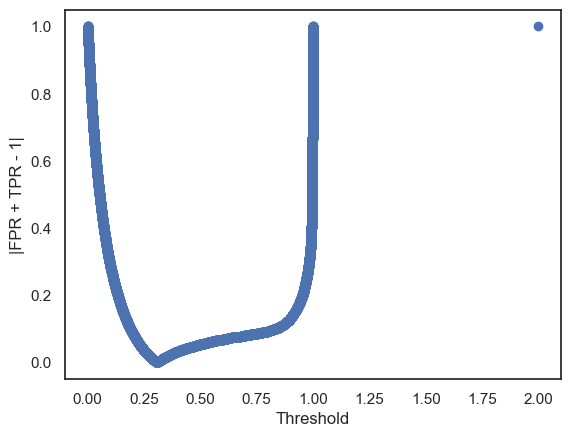

In [90]:
plt.scatter(thresholds,np.abs(fpr_test+tpr_test-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [91]:
min_threshold=thresholds[np.argmin(np.abs(fpr_test+tpr_test-1))]
#0.33537486
#https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/

In [92]:
min_threshold

0.30800962

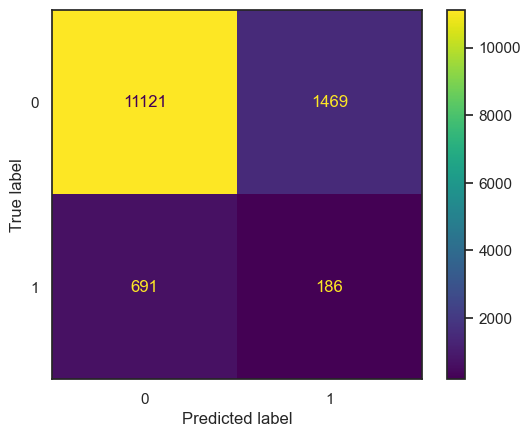

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     12590
           1       0.11      0.21      0.15       877

    accuracy                           0.84     13467
   macro avg       0.53      0.55      0.53     13467
weighted avg       0.89      0.84      0.86     13467



In [93]:
y_pred_xgb_threshold=(xgbmodel.predict_proba(X_test)[:,1]>min_threshold).astype('float')
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb_threshold)
plt.show()
print(classification_report(y_test,y_pred_xgb_threshold))

In [94]:
metrics_df=pd.DataFrame(columns=["Model","Accuracy","Precision","Recall","F1-score"])

In [95]:
metrics_df.loc[len(metrics_df)]={"Model":"Logistic Regression","Accuracy":metrics.accuracy_score(y_test,y_pred),"Precision":metrics.precision_score(y_test,y_pred),"Recall":metrics.recall_score(y_test,y_pred),"F1-score":metrics.f1_score(y_test,y_pred)}

In [96]:
metrics_df.loc[len(metrics_df)]={"Model":"Decision Tree","Accuracy":metrics.accuracy_score(y_test,y2_pred),"Precision":metrics.precision_score(y_test,y2_pred),"Recall":metrics.recall_score(y_test,y2_pred),"F1-score":metrics.f1_score(y_test,y2_pred)}

In [97]:
metrics_df.loc[len(metrics_df)]={"Model":"Random Forest","Accuracy":metrics.accuracy_score(y_test,y3_pred),"Precision":metrics.precision_score(y_test,y3_pred),"Recall":metrics.recall_score(y_test,y3_pred),"F1-score":metrics.f1_score(y_test,y3_pred)}

In [98]:
metrics_df.loc[len(metrics_df)]={"Model":"XGBoost","Accuracy":metrics.accuracy_score(y_test,y_pred_xgb_threshold),"Precision":metrics.precision_score(y_test,y_pred_xgb_threshold),"Recall":metrics.recall_score(y_test,y_pred_xgb_threshold),"F1-score":metrics.f1_score(y_test,y_pred_xgb_threshold)}

In [99]:
metrics_df.loc[len(metrics_df)]={"Model":"Artificial Neural Network","Accuracy":metrics.accuracy_score(y_test,y_pred_nn),"Precision":metrics.precision_score(y_test,y_pred_nn),"Recall":metrics.recall_score(y_test,y_pred_nn),"F1-score":metrics.f1_score(y_test,y_pred_nn)}

In [100]:
metrics_df

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.493948,0.084290,0.686431,0.150143
1,Decision Tree,0.794089,0.088184,0.231471,0.127713
2,Random Forest,0.763570,0.092259,0.297605,0.140853
3,XGBoost,0.839608,0.112387,0.212087,0.146919
4,Artificial Neural Network,0.697334,0.096799,0.437856,0.158547
